<center>

# FraudHunter

### <i> Progetto per l'esame di Programmazione di applicazioni Data Intensive (2025) </i>

### Alessandro Valmori
#### Matricola: 0001089308
#### alessandro.valmori2@studio.unibo.it
</center>

## 1. Introduzione e Obiettivo del Progetto

Questo progetto si concentra sull'analisi di un dataset di transazioni con carte di credito al fine di addestrare e validare modelli di classificazione capaci di identificare transazioni fraudolente. Le frodi con carta di credito rappresentano un problema significativo per le istituzioni finanziarie e i consumatori, rendendo cruciale lo sviluppo di sistemi di rilevamento efficaci.

L'obiettivo principale è esplorare il dataset, preparare i dati per il machine learning, addestrare almeno due (preferibilmente tre o più) modelli di classificazione, valutarne le performance con metriche appropriate (data la natura sbilanciata del problema) e ottimizzare gli iperparametri di almeno un modello.

Il dataset utilizzato è "Credit Card Fraud Detection" disponibile su Kaggle, noto per il suo forte sbilanciamento tra classi (pochissime frodi rispetto alle transazioni legittime).

## 2. Setup dell'Ambiente e Caricamento Librerie

In questa sezione, importiamo tutte le librerie Python necessarie per l'analisi dei dati, la visualizzazione, il preprocessing, la modellazione e la valutazione.

In [28]:

import os
import json

import kagglehub
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy.stats import randint
import xgboost as xgb

from sklearn.model_selection import (
    train_test_split, 
    RandomizedSearchCV, 
    StratifiedKFold,
    GridSearchCV 
)
from sklearn.preprocessing import (
    StandardScaler, 
    RobustScaler,
    PolynomialFeatures 
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel 
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix, 
    classification_report, 
    roc_auc_score,
    precision_recall_curve, 
    average_precision_score
)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.pipeline import Pipeline as ImbPipeline

from statsmodels.stats.contingency_tables import mcnemar
from itertools import combinations

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 3. Descrizione e Caricamento del Dataset

Utilizziamo il dataset "Credit Card Fraud Detection" da Kaggle. Questo dataset contiene transazioni effettuate con carte di credito europee nel settembre 2013. Presenta 284.807 transazioni, di cui solo 492 sono fraudolente (circa lo 0.172%).
Le feature `V1` a `V28` sono il risultato di una trasformazione PCA applicata ai dati originali per ragioni di confidenzialità. Le uniche feature non trasformate da PCA sono `Time` (secondi trascorsi tra ogni transazione e la prima transazione nel dataset) e `Amount` (l'importo della transazione). La variabile target è `Class`, che vale 1 in caso di frode e 0 altrimenti.

Procediamo con il caricamento e una prima ispezione del dataset.

In [29]:
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")
data_subdir_name = "data"
target_data_dir = os.path.join(current_dir, data_subdir_name)
print(f"Target directory for dataset: {target_data_dir}")

os.makedirs(target_data_dir, exist_ok=True) 

dataset_slug = "mlg-ulb/creditcardfraud"
print(f"\nDownloading dataset '{dataset_slug}' with KaggleHub...")
try:
    dataset_path_in_cache = kagglehub.dataset_download(dataset_slug)
    print(f"Dataset downloaded to KaggleHub cache: {dataset_path_in_cache}")
    expected_file_name = "creditcard.csv"
    source_file_path = os.path.join(dataset_path_in_cache, expected_file_name)
    destination_file_path = os.path.join(target_data_dir, expected_file_name)

    if os.path.exists(source_file_path):
        print(f"\nFound dataset file in cache at: {source_file_path}")
        print(f"Copying '{source_file_path}' to '{destination_file_path}'...")
        shutil.copy2(source_file_path, destination_file_path) 
        
        if os.path.exists(destination_file_path):
            print(f"Successfully copied '{expected_file_name}' to '{target_data_dir}'.")
            print(f"File is now available at: {destination_file_path}")
        else:
            print(f"Error: File copying failed. '{destination_file_path}' not found after copy attempt.")
            
    else:
        print(f"\nError: File '{expected_file_name}' not found in the KaggleHub cache directory: {dataset_path_in_cache}.")
        if os.path.exists(dataset_path_in_cache) and os.path.isdir(dataset_path_in_cache):
            print(f"Files available in cache directory are: {os.listdir(dataset_path_in_cache)}")
        else:
            print(f"The cache path '{dataset_path_in_cache}' does not seem to be a valid directory.")

except Exception as e:
    print(f"\nAn error occurred: {e}")

Current working directory: /home/siralex/Desktop/CREDIT_CARD/notebooks
Target directory for dataset: /home/siralex/Desktop/CREDIT_CARD/notebooks/data

Dataset downloaded to KaggleHub cache: /home/siralex/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3

Found dataset file in cache at: /home/siralex/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3/creditcard.csv
Copying '/home/siralex/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3/creditcard.csv' to '/home/siralex/Desktop/CREDIT_CARD/notebooks/data/creditcard.csv'...
Successfully copied 'creditcard.csv' to '/home/siralex/Desktop/CREDIT_CARD/notebooks/data'.
File is now available at: /home/siralex/Desktop/CREDIT_CARD/notebooks/data/creditcard.csv


In [30]:
try:
    df = pd.read_csv('data/creditcard.csv')
    pd.options.display.max_colwidth = 500
    print("Dataset caricato con successo.")
    print(f"Dimensioni del dataset: {df.shape}")
except FileNotFoundError:
    print("Errore: creditcard.csv non trovato. Assicurati che il file sia nella directory corretta.")

Dataset caricato con successo.
Dimensioni del dataset: (284807, 31)


## 4. Analisi Esplorativa dei Dati (EDA)

L'Analisi Esplorativa dei Dati (EDA) è fondamentale per comprendere la struttura del dataset, le distribuzioni delle variabili, le correlazioni e identificare eventuali problemi o pattern interessanti.

### 4.1. Analisi della Variabile Target (`Class`)
Iniziamo analizzando la distribuzione della variabile target per quantificare lo sbilanciamento.

In [31]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [33]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [34]:

X_original = df.drop('Class', axis=1)
y_original = df['Class']

# Suddivisione in training e test set, stratificando su y
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_original, y_original, test_size=0.2, random_state=42, stratify=y_original
)

print(f"\nForma di X_train_orig: {X_train_orig.shape}, X_test_orig: {X_test_orig.shape}")
print(f"Distribuzione classi in y_train_orig:\n{y_train_orig.value_counts(normalize=True)}")
print(f"Distribuzione classi in y_test_orig:\n{y_test_orig.value_counts(normalize=True)}")

y_test = y_test_orig.copy()


Forma di X_train_orig: (227845, 30), X_test_orig: (56962, 30)
Distribuzione classi in y_train_orig:
Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64
Distribuzione classi in y_test_orig:
Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64


Come osservato, il dataset è estremamente sbilanciato: solo lo 0.17% delle transazioni sono etichettate come fraudolente. Questo sbilanciamento è una caratteristica cruciale che influenzerà la scelta delle metriche di valutazione e delle tecniche di modellazione (ad esempio, la necessità di tecniche di ricampionamento come SMOTE o l'uso di pesi di classe).

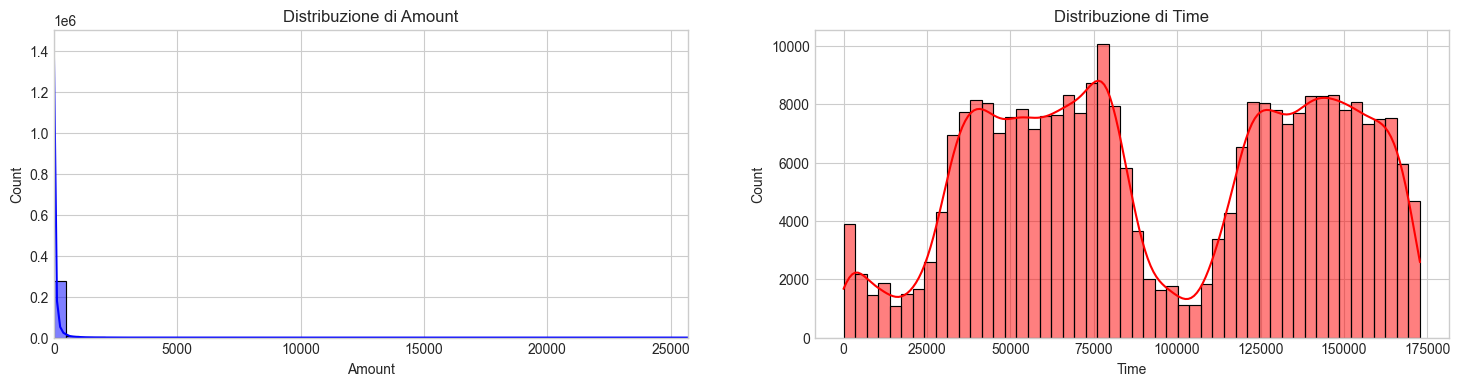

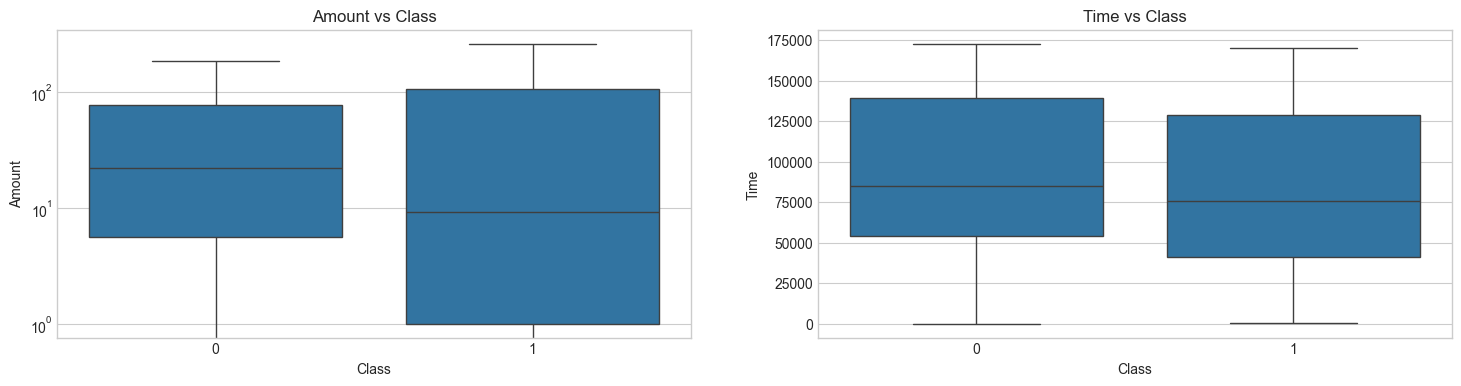

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(df['Amount'], ax=ax[0], color='b', bins=50, kde=True)
ax[0].set_title('Distribuzione di Amount')
ax[0].set_xlim([min(df['Amount']), max(df['Amount'])])

sns.histplot(df['Time'], ax=ax[1], color='r', bins=50, kde=True)
ax[1].set_title('Distribuzione di Time')
plt.show()

fig2, ax2 = plt.subplots(1, 2, figsize=(18, 4))
sns.boxplot(x='Class', y='Amount', data=df, showfliers=False, ax=ax2[0])
ax2[0].set_title('Amount vs Class')
ax2[0].set_yscale('log')

sns.boxplot(x='Class', y='Time', data=df, ax=ax2[1])
ax2[1].set_title('Time vs Class')
plt.show()

**Osservazioni su `Time` e `Amount`:**

Dall'analisi grafica delle distribuzioni delle feature `Time` e `Amount`, possiamo trarre le seguenti considerazioni:

-   **Amount:**
    -   L'istogramma della feature `Amount` mostra una distribuzione fortemente asimmetrica a destra (right-skewed). Ciò indica che la maggior parte delle transazioni ha un importo relativamente piccolo, mentre un numero limitato di transazioni ha importi molto elevati (outlier).
    -   Il boxplot che confronta `Amount` per le transazioni fraudolente (`Class=1`) e quelle legittime (`Class=0`), specialmente quando visualizzato con una scala logaritmica sull'asse y per una migliore leggibilità, suggerisce che, sebbene ci sia una notevole sovrapposizione, la distribuzione degli importi per le transazioni fraudolente potrebbe avere caratteristiche leggermente diverse (ad esempio, una diversa mediana o range interquartile) rispetto a quelle legittime. Nonostante ciò, gli importi da soli non sembrano essere un discriminante forte. La rimozione degli outlier grafici (`showfliers=False`) aiuta a concentrarsi sul corpo principale delle distribuzioni.

-   **Time:**
    -   La feature `Time` rappresenta i secondi trascorsi tra ciascuna transazione e la prima transazione registrata nel dataset.
    -   L'istogramma di `Time` mostra un pattern bimodale. Questo andamento potrebbe riflettere cicli di attività giornalieri, come ad esempio una diminuzione del numero di transazioni durante le ore notturne e picchi durante le ore diurne/serali.
    -   Il boxplot che confronta `Time` per le due classi non rivela, a una prima analisi, pattern immediatamente evidenti.
    -   **Feature Engineering su `Time`**: Per catturare meglio i pattern ciclici giornalieri, trasformeremo la feature `Time` in due nuove feature: `sin_time_day` e `cos_time_day`. Queste rappresenteranno l'ora del giorno in modo ciclico, il che potrebbe essere più informativo per i modelli rispetto al semplice conteggio dei secondi. Queste nuove feature, essendo già in un range definito (-1 a 1), non necessiteranno di un ulteriore scaling separato come `Amount`, ma verranno processate insieme alle altre feature PCA.

### 4.3. Analisi delle Correlazioni
Esaminiamo la correlazione tra le features e la variabile target. Poiché le features `V1-V28` sono componenti PCA, ci aspettiamo che siano largamente incorrelate tra loro. La correlazione con la classe target può invece darci indicazioni sulle features potenzialmente più informative.

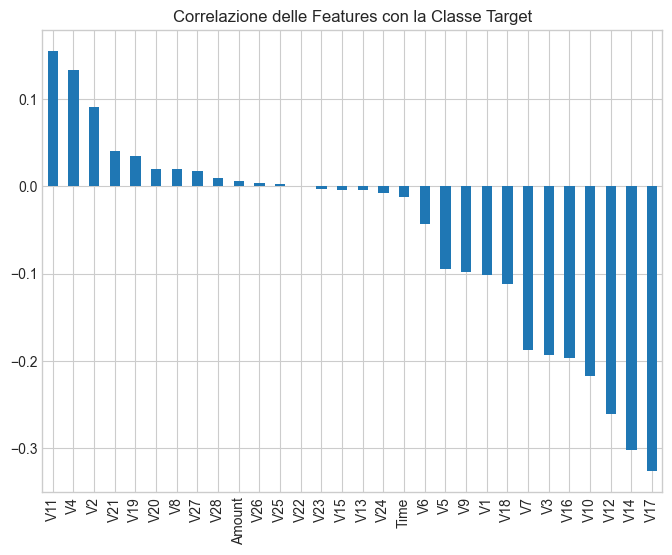

In [36]:
correlation_with_target = df.corr()['Class'].sort_values(ascending=False)
plt.figure(figsize=(8, 6))
correlation_with_target.drop('Class').plot(kind='bar')
plt.title('Correlazione delle Features con la Classe Target')
plt.show()

**Osservazioni sulle Correlazioni:**

Il grafico a barre (generato dalla cella di codice 5) visualizza le correlazioni di Pearson tra ciascuna feature e la variabile target `Class`. Queste correlazioni ci forniscono una prima indicazione quantitativa della relazione lineare tra le singole feature e la probabilità che una transazione sia fraudolenta.

-   **Correlazioni Negative Marcate:**
    Alcune features PCA, in particolare `V17`, `V14`, `V12`, e `V10`, mostrano una correlazione negativa relativamente più marcata con la classe `Class`. Questo suggerisce che valori più bassi (o più negativi, data la natura delle componenti PCA) di queste features sono associati a una maggiore probabilità che la transazione sia una frode. Ad esempio, `V17` ha la correlazione negativa più forte.

-   **Correlazioni Positive Marcate:**
    Altre features PCA, come `V11`, `V4`, e `V2`, mostrano una correlazione positiva con la classe `Class`. Questo indica che valori più alti di queste features potrebbero essere associati a una maggiore probabilità di frode. `V11` spicca con la correlazione positiva più forte.

-   **Correlazioni Deboli:**
    Le feature `Amount` e `Time` mostrano correlazioni lineari molto deboli con `Class`. Questo è un risultato atteso per `Amount`, data la sua ampia e sovrapposta distribuzione vista in precedenza. Per `Time`, la debole correlazione lineare non esclude la possibilità di relazioni non lineari o pattern temporali più complessi che potrebbero essere utili (ma che non esploreremo in dettaglio in questo progetto oltre lo scaling). Anche molte altre features PCA (`V20` a `V28`, `V1` a `V9` con alcune eccezioni) hanno correlazioni vicine allo zero.

**Implicazioni:**
Le features con correlazioni (positive o negative) di magnitudine maggiore sono candidati promettenti per essere informative nei modelli di classificazione. Tuttavia, è importante ricordare che:
1.  La correlazione di Pearson misura solo relazioni lineari.
2.  Le features PCA sono combinazioni lineari delle feature originali (sconosciute) e, sebbene siano ortogonali tra loro, la loro correlazione individuale con il target non racconta l'intera storia. Interazioni tra feature potrebbero essere cruciali.
3.  Modelli più complessi (come Random Forest e XGBoost) sono in grado di catturare relazioni non lineari e interazioni che questa semplice analisi di correlazione potrebbe non evidenziare.

Nonostante ciò, questa analisi fornisce una prima scrematura utile e conferma che alcune delle componenti PCA contengono segnale rilevante per la distinzione tra frodi e transazioni legittime.

### 4.4. Distribuzione di Alcune Features PCA per Classe
Visualizziamo le distribuzioni di densità (KDE) per alcune delle features PCA che hanno mostrato una correlazione più significativa con la classe target, separando le transazioni legittime da quelle fraudolente. Questo può aiutarci a capire se ci sono differenze visibili nelle distribuzioni.

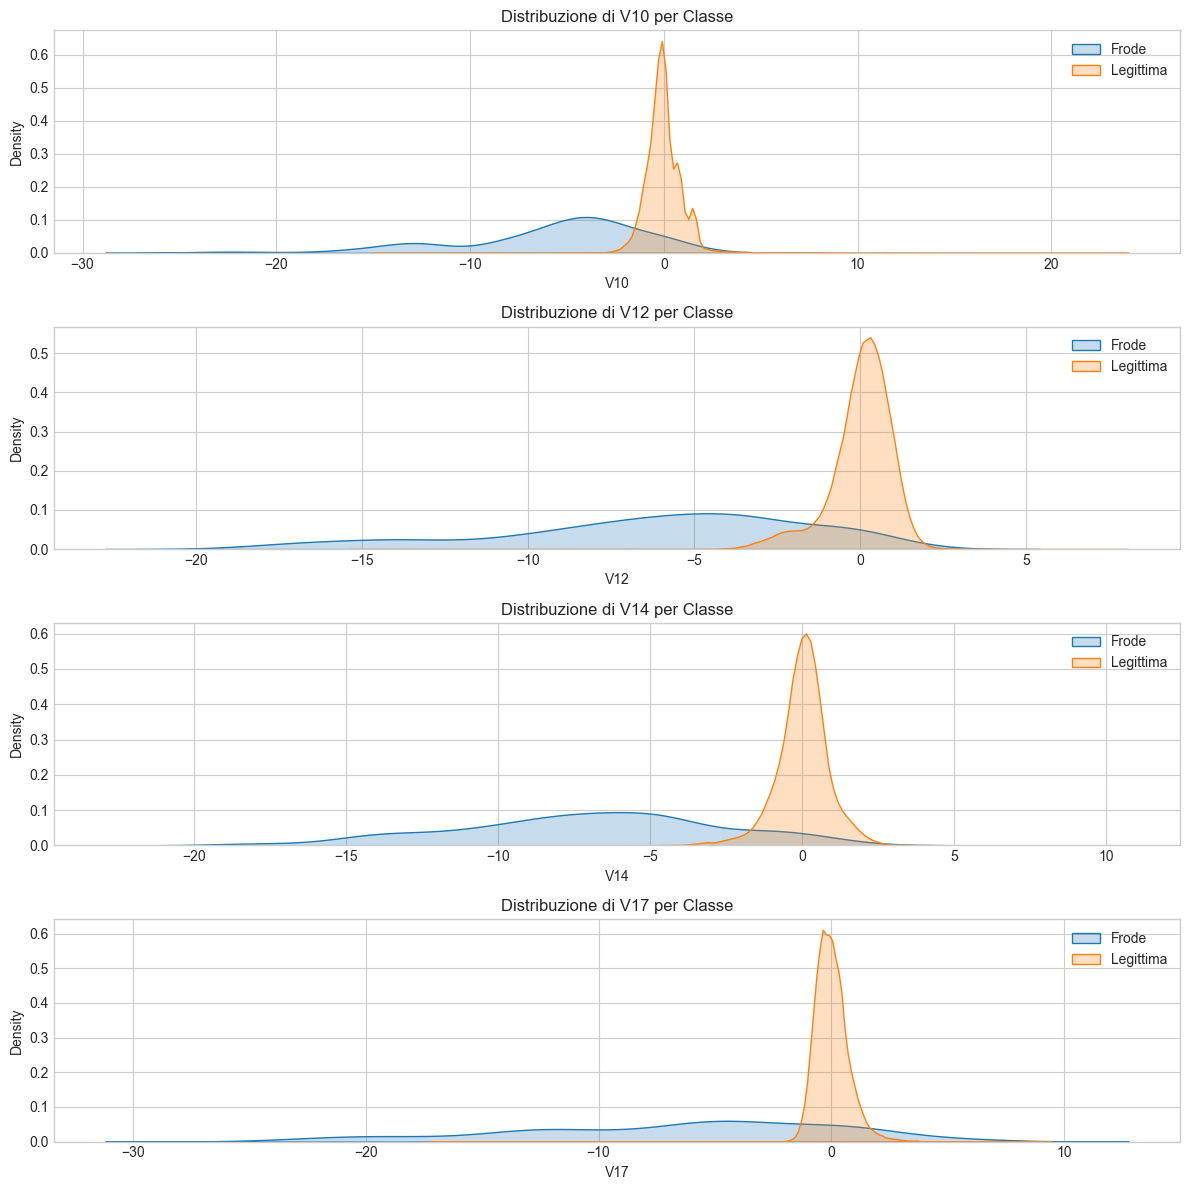

In [37]:
var_to_plot = ['V10', 'V12', 'V14', 'V17']
plt.figure(figsize=(12, len(var_to_plot)*3))
for i, var in enumerate(var_to_plot):
    plt.subplot(len(var_to_plot), 1, i+1)
    sns.kdeplot(df[var][df.Class == 1], label="Frode", fill=True)
    sns.kdeplot(df[var][df.Class == 0], label="Legittima", fill=True)
    plt.title(f'Distribuzione di {var} per Classe')
    plt.legend()
plt.tight_layout()
plt.show()

## 5. Preparazione dei Dati per il Machine Learning

1.  **Feature Engineering per `Time`**:
    * **Motivazione**: La feature `Time` originale rappresenta i secondi trascorsi dalla prima transazione. Per catturare meglio i pattern ciclici giornalieri, che potrebbero essere rilevanti per il rilevamento frodi (es. frodi più frequenti in certe ore), questa feature è stata trasformata.
    * **Metodo Scelto**: Abbiamo calcolato l'ora del giorno in secondi (`Time % (24*60*60)`). Per preservare la natura ciclica di questa informazione (dove 23:59 è vicino a 00:00), abbiamo applicato una trasformazione seno e coseno, creando due nuove feature: `sin_time_day` e `cos_time_day`. Queste feature variano tra -1 e 1 e rappresentano la posizione nel ciclo giornaliero.
    * **Applicazione**: Questa trasformazione è stata applicata sia al training set che al test set, basandosi sui valori originali di `Time`.

2.  **Scaling della Feature `Amount`**:
    * **Motivazione**: La feature `Amount` ha una scala e distribuzione molto diversa rispetto alle feature PCA (`V1-V28`) e presenta outlier significativi. Modelli sensibili alla scala delle feature beneficiano dello scaling.
    * **Metodo Scelto**: Si è utilizzato `RobustScaler` da `sklearn.preprocessing` per `Amount`, data la sua robustezza agli outlier.
    * **Applicazione**: `RobustScaler` viene *fittato* **solo** sul training set (`X_train_orig['Amount']`) e poi utilizzato per *trasformare* sia `Amount` nel training set che nel test set. Lo scaler fittato (`scaler_amount`) viene salvato.

3.  **Separazione Features e Target**:
    * Si sono già implicitamente separate le features (`X_original`) dalla variabile target (`y_original`) dopo il caricamento dei dati. Questa separazione è standard per problemi di apprendimento supervisionato.

4.  **Suddivisione in Training e Test Set**:
    * **Motivazione**: È fondamentale dividere il dataset in un insieme di addestramento (su cui il modello impara) e un insieme di test (su cui il modello viene valutato in modo imparziale per stimare le sue performance su dati mai visti).
    * **Metodo Scelto**: Si è utilizzato `train_test_split` da `sklearn.model_selection` con un rapporto 80/20 (80% training, 20% test).
    * **Stratificazione**: Data la forte natura sbilanciata del target `Class`, è stato essenziale utilizzare il parametro `stratify=y_original`. Questo assicura che la proporzione di transazioni fraudolente e legittime sia mantenuta sia nel training set (`y_train_orig`) che nel test set (`y_test_orig`), garantendo che entrambi i set siano rappresentativi della distribuzione originale delle classi.

5.  **Gestione dello Sbilanciamento delle Classi (nel Training Set)**:
    * **Motivazione**: Con solo lo 0.17% di frodi, la maggior parte dei classificatori standard tenderebbe a favorire la classe maggioritaria (transazioni legittime), ottenendo un'alta accuracy ma fallendo nel rilevare le frodi (basso recall per la classe frode).
    * **Metodo Scelto**: Si applicherà la tecnica SMOTE (Synthetic Minority Over-sampling Technique) da `imblearn.over_sampling`. SMOTE funziona creando campioni sintetici per la classe minoritaria (frodi) basandosi sui suoi vicini più prossimi nello spazio delle feature. Questo aiuta a bilanciare la distribuzione delle classi nel training set, permettendo al modello di apprendere meglio le caratteristiche distintive delle frodi.
    * **Applicazione Cruciale**: È di fondamentale importanza applicare SMOTE **solo e unicamente sul training set (`X_train_prepared`, `y_train_orig`) e <em>dopo</em> la suddivisione iniziale in training e test**. Applicare SMOTE prima dello split o sull'intero dataset (incluso il test set) porterebbe a data leakage: il modello verrebbe addestrato (o il test set contaminato) con informazioni sintetiche che sono derivate anche da campioni che finiranno nel test set, portando a una stima eccessivamente ottimistica delle performance. Il test set (`X_test_prepared`, `y_test`) deve rimanere "incontaminato" e riflettere la distribuzione reale dei dati per una valutazione onesta.

In [38]:
seconds_in_day = 24 * 60 * 60

# Per X_train_orig
time_day_train = X_train_orig['Time'] % seconds_in_day
X_train_prepared = X_train_orig.copy()
X_train_prepared['sin_time_day'] = np.sin(2 * np.pi * time_day_train / seconds_in_day)
X_train_prepared['cos_time_day'] = np.cos(2 * np.pi * time_day_train / seconds_in_day)

# Per X_test_orig
time_day_test = X_test_orig['Time'] % seconds_in_day
X_test_prepared = X_test_orig.copy()
X_test_prepared['sin_time_day'] = np.sin(2 * np.pi * time_day_test / seconds_in_day)
X_test_prepared['cos_time_day'] = np.cos(2 * np.pi * time_day_test / seconds_in_day)

# Scaling solo per 'Amount'
scaler_amount = RobustScaler()
X_train_scaled_amount = scaler_amount.fit_transform(X_train_prepared['Amount'].values.reshape(-1, 1))
X_test_scaled_amount = scaler_amount.transform(X_test_prepared['Amount'].values.reshape(-1, 1))
joblib.dump(scaler_amount, 'scaler_amount.joblib')
print("Scaler per Amount (fittato su X_train originale) salvato in: scaler_amount.joblib")

# Aggiungi 'scaled_amount' e droppa 'Time' e 'Amount' originali
X_train_prepared['scaled_amount'] = X_train_scaled_amount
X_test_prepared['scaled_amount'] = X_test_scaled_amount

X_train_prepared.drop(['Time', 'Amount'], axis=1, inplace=True)
X_test_prepared.drop(['Time', 'Amount'], axis=1, inplace=True)

print("\nFeature 'Time' trasformata in 'sin_time_day' e 'cos_time_day'.")
print("Feature 'Amount' scalata come 'scaled_amount'.")
print(f"Nuove colonne in X_train_prepared: {X_train_prepared.columns.tolist()}")
print(f"Nuove colonne in X_test_prepared: {X_test_prepared.columns.tolist()}")
print(f"Forma di X_train_prepared: {X_train_prepared.shape}")
print(f"Forma di X_test_prepared: {X_test_prepared.shape}")

Scaler per Amount (fittato su X_train originale) salvato in: scaler_amount.joblib

Feature 'Time' trasformata in 'sin_time_day' e 'cos_time_day'.
Feature 'Amount' scalata come 'scaled_amount'.
Nuove colonne in X_train_prepared: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'sin_time_day', 'cos_time_day', 'scaled_amount']
Nuove colonne in X_test_prepared: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'sin_time_day', 'cos_time_day', 'scaled_amount']
Forma di X_train_prepared: (227845, 31)
Forma di X_test_prepared: (56962, 31)


## 6. Addestramento e Validazione dei Modelli di Classificazione

In questa sezione, si addestrano e si valutano tre diversi modelli di classificazione:

1.  **Regressione Logistica con regolarizzazione L1 (LASSO)**: Un modello lineare di base, ma con regolarizzazione L1 che può aiutare nella feature selection e prevenire l'overfitting. Verrà esplorata anche in combinazione con feature polinomiali per catturare possibili non linearità.
2.  **Random Forest Classifier**: Un modello basato su ensemble di alberi decisionali, generalmente robusto e capace di catturare interazioni complesse.
3.  **XGBoost Classifier**: Un'implementazione ottimizzata e potente di gradient boosting, spesso tra i modelli più performanti in molteplici task di classificazione.

Per la valutazione, data la natura sbilanciata del dataset, ci concentreremo su metriche come:

-   **Precision (per la classe frode)**: Di tutte le transazioni predette come frode, quante lo sono realmente? (TP / (TP + FP))
-   **Recall (per la classe frode)**: Di tutte le transazioni fraudolente reali, quante sono state identificate correttamente? (TP / (TP + FN)) - Questa è spesso la metrica più importante in questo contesto, poiché mancare una frode (Falso Negativo) è solitamente più costoso di un falso allarme (Falso Positivo).
-   **F1-Score (per la classe frode)**: La media armonica di Precision e Recall, utile per bilanciare le due.
-   **AUC-ROC (Area Under the Receiver Operating Characteristic Curve)**: Misura la capacità del modello di distinguere tra le classi attraverso varie soglie.
-   **AUC-PR (Area Under the Precision-Recall Curve)**: Particolarmente informativa per dataset sbilanciati, rappresenta la media delle precision a diversi valori di soglia ed è spesso preferita all'AUC-ROC in contesti di forte sbilanciamento.
-   **Confusion Matrix**: Per visualizzare il numero di Veri Positivi (TP), Falsi Positivi (FP), Veri Negativi (TN) e Falsi Negativi (FN).

Definiamo prima le funzioni ausiliarie per calcolare e visualizzare queste metriche, che verranno riutilizzataeper ciascun modello.

In [39]:

from scipy.stats import norm # Per calcolare il valore Z

model_prefixes = ["LR", "RF", "XGB", "RF-OPT"]

def calculate_confidence_interval(accuracy, n_samples, confidence_level=0.95):

    if n_samples == 0:
        return (np.nan, np.nan)
    if n_samples <= 30: 
        print(f"Attenzione: N={n_samples} potrebbe essere piccolo per l'approssimazione normale usata per l'IC.")

    # Calcola Z per il livello di confidenza specificato (due code)
    alpha = 1 - confidence_level
    z = norm.ppf(1 - alpha / 2)

    f = accuracy
    N = n_samples

    term_z_sq_over_2N = (z**2) / (2 * N)
    discriminant_term_numerator = (f * (1 - f) / N) + (z**2 / (4 * N**2)) 

    if discriminant_term_numerator < 0:
        print(f"Attenzione: Discriminante negativo ({discriminant_term_numerator:.4f}) nel calcolo dell'IC. N={N}, f={f:.4f}. L'approssimazione potrebbe non essere valida.")
        return (np.nan, np.nan)

    sqrt_discriminant = np.sqrt(discriminant_term_numerator)
    denominator = 1 + (z**2 / N)

    p_lower = (f + term_z_sq_over_2N - z * sqrt_discriminant) / denominator
    p_upper = (f + term_z_sq_over_2N + z * sqrt_discriminant) / denominator
    
    p_lower = max(0, p_lower)
    p_upper = min(1, p_upper)

    return (p_lower, p_upper)


def evaluate_model(y_true, y_pred, y_pred_proba=None, model_name="Modello", n_test_samples=None, confidence_level=0.95):
    print(f"--- Valutazione: {model_name} ---")
    current_accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {current_accuracy:.4f}")
    
    if n_test_samples is not None and n_test_samples > 0:
        acc_lower, acc_upper = calculate_confidence_interval(current_accuracy, n_test_samples, confidence_level)
        if not (np.isnan(acc_lower) or np.isnan(acc_upper)):
             print(f"  Intervallo di Confidenza ({confidence_level*100:.0f}%) per Accuracy: [{acc_lower:.4f} - {acc_upper:.4f}]")
        else:
            print(f"  Impossibile calcolare l'intervallo di confidenza per l'accuratezza con N={n_test_samples}.")
    else:
        print("  Numero di campioni di test non fornito o non valido, impossibile calcolare l'intervallo di confidenza per l'accuratezza.")
    
    print(f"Precision (Fraud): {precision_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"Recall (Fraud): {recall_score(y_true, y_pred, pos_label=1):.4f}") 
    print(f"F1-Score (Fraud): {f1_score(y_true, y_pred, pos_label=1):.4f}")  
    if y_pred_proba is not None:
        print(f"ROC AUC Score: {roc_auc_score(y_true, y_pred_proba[:, 1]):.4f}")
        avg_precision = average_precision_score(y_true, y_pred_proba[:, 1], pos_label=1)
        print(f"Average Precision (AUC-PR): {avg_precision:.4f}") 
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predetto')
    plt.ylabel('Reale')
    plt.title('Confusion Matrix')
    plt.show()
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Legittima (0)', 'Frode (1)']))
    print("--------------------------------------\n")

    return {
        'model': model_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_fraud': precision_score(y_true, y_pred, pos_label=1, zero_division=0),
        'recall_fraud': recall_score(y_true, y_pred, pos_label=1, zero_division=0),
        'f1_fraud': f1_score(y_true, y_pred, pos_label=1, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_pred_proba[:, 1]) if y_pred_proba is not None else None,
        'auc_pr': average_precision_score(y_true, y_pred_proba[:, 1], pos_label=1) if y_pred_proba is not None else None
    }

model_results = []

In [40]:

def plot_precision_recall_curve(y_true, y_pred_proba_positive_class, model_name_for_plot, save_filename=None):

    precision_vals, recall_vals, _ = precision_recall_curve(
        y_true,
        y_pred_proba_positive_class,
        pos_label=1
    )
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.plot(recall_vals, precision_vals, marker='.', markersize=5, linestyle='-', linewidth=1.5, label=model_name_for_plot)
    ax.set_xlabel('Recall (Frode)', fontsize=12)
    ax.set_ylabel('Precision (Frode)', fontsize=12)
    ax.set_title(f'Curva Precision-Recall\n{model_name_for_plot}', fontsize=14)
    ax.legend(fontsize=10, loc='lower left')
    ax.grid(True, linestyle=':', alpha=0.7)
    auc_pr_score_plot = average_precision_score(y_true, y_pred_proba_positive_class, pos_label=1)
    ax.text(0.6, 0.05, f'AUC-PR: {auc_pr_score_plot:.4f}', transform=ax.transAxes, fontsize=12,
            bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))
    plt.tight_layout()
    if save_filename:
        plt.savefig(save_filename)
    plt.show()
    plt.close(fig)


def find_and_save_optimal_f1_threshold(y_true, y_pred_proba_positive_class, model_name_prefix, model_description_for_print="Modello"):
    precision_vals, recall_vals, thresholds_prc = precision_recall_curve(
        y_true,
        y_pred_proba_positive_class,
        pos_label=1
    )

    optimal_threshold = None
    optimal_f1_value = 0.0
    corresponding_precision = 0.0
    corresponding_recall = 0.0

    if len(thresholds_prc) == 0:
        print(f"Attenzione: Nessuna soglia trovata da precision_recall_curve per {model_description_for_print}. Impossibile ottimizzare la soglia.")
        return optimal_threshold, optimal_f1_value, corresponding_precision, corresponding_recall

    precisions_for_thresholds = precision_vals[:-1]
    recalls_for_thresholds = recall_vals[:-1]

    denominator_f1 = precisions_for_thresholds + recalls_for_thresholds
    f1_scores = np.zeros_like(denominator_f1)
    valid_indices_f1 = denominator_f1 > 1e-9
    f1_scores[valid_indices_f1] = (2 * precisions_for_thresholds[valid_indices_f1] * recalls_for_thresholds[valid_indices_f1]) / \
                                  denominator_f1[valid_indices_f1]

    if len(f1_scores) > 0:
        idx_optimal = np.argmax(f1_scores)
        optimal_f1_value = f1_scores[idx_optimal]
        optimal_threshold = thresholds_prc[idx_optimal]
        corresponding_precision = precisions_for_thresholds[idx_optimal]
        corresponding_recall = recalls_for_thresholds[idx_optimal]

        print(f"\nSoglia per {model_description_for_print} (Max F1-Score): {optimal_threshold:.4f}")
        print(f"  Con questa soglia -> F1-Score: {optimal_f1_value:.4f}, Precision: {corresponding_precision:.4f}, Recall: {corresponding_recall:.4f}")

        threshold_to_save_content = {'thresh': float(optimal_threshold)} 
        threshold_output_filename = f"{model_name_prefix}_thresh.json"
        try:
            with open(threshold_output_filename, 'w') as f:
                json.dump(threshold_to_save_content, f, indent=4)
            print(f"Soglia ottimale per F1 ({model_description_for_print}: {float(optimal_threshold):.4f}) salvata in '{threshold_output_filename}'")
        except Exception as e:
            print(f"Errore durante il salvataggio della soglia in '{threshold_output_filename}': {e}")
    else:
        print(f"Attenzione: Non è stato possibile calcolare F1-scores validi per l'ottimizzazione di {model_description_for_print}.")
        return None, 0, 0, 0

    return optimal_threshold, optimal_f1_value, corresponding_precision, corresponding_recall

### 6.1. Regressione Logistica 

Numero di feature selezionate inizialmente: 10
Feature selezionate: ['V2', 'V16', 'V7', 'V3', 'V17', 'V11', 'V12', 'V4', 'V10', 'V14']

Caricamento iperparametri da 'best_LR_C.json'...
Iperparametri caricati: {'lasso_logreg__C': 0.003727593720314938}

--- Addestramento Pipeline con Iperparametri Ottimali Caricati ---
Pipeline addestrata con iperparametri caricati.
--- Valutazione: LogReg Default Thresh C=0.0037 ---
Accuracy: 0.9749
  Intervallo di Confidenza (95%) per Accuracy: [0.9736 - 0.9762]
Precision (Fraud): 0.0596
Recall (Fraud): 0.9184
F1-Score (Fraud): 0.1120
ROC AUC Score: 0.9748
Average Precision (AUC-PR): 0.7914

Confusion Matrix:


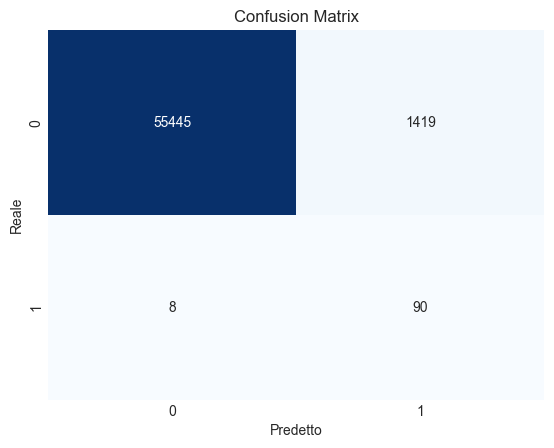


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      0.98      0.99     56864
    Frode (1)       0.06      0.92      0.11        98

     accuracy                           0.97     56962
    macro avg       0.53      0.95      0.55     56962
 weighted avg       1.00      0.97      0.99     56962

--------------------------------------

Modello e colonne input salvati.


In [41]:
rf_for_selection = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    class_weight='balanced_subsample',
    n_jobs=-1 
)
rf_for_selection.fit(X_train_prepared, y_train_orig)

N_FEATURES_TO_PRESELECT = 10 
importances = rf_for_selection.feature_importances_
selected_indices = np.argsort(importances)[-N_FEATURES_TO_PRESELECT:]
selected_feature_names_initial = X_train_prepared.columns[selected_indices].tolist()

X_train_fs = X_train_prepared[selected_feature_names_initial]
X_test_fs = X_test_prepared[selected_feature_names_initial]

print(f"Numero di feature selezionate inizialmente: {len(selected_feature_names_initial)}")
print(f"Feature selezionate: {selected_feature_names_initial}")

pipeline_lasso_poly = ImbPipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('lasso_logreg', LogisticRegression(
        penalty='l1', 
        solver='liblinear', 
        random_state=42, 
        max_iter=1500, 
        tol=0.001
    ))
])

param_grid_lasso_logreg = {
    'lasso_logreg__C': np.logspace(-3, 1, 8) 
}

cv_stratified_lasso = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search_lasso_poly = GridSearchCV(
    estimator=pipeline_lasso_poly,
    param_grid=param_grid_lasso_logreg,
    scoring='average_precision',
    cv=cv_stratified_lasso,
    verbose=1,
    n_jobs=-1
)

hyperparams_filename_lasso_poly = f'best_LR_C.json'
FORCE_NEW_SEARCH_LASSO_POLY = False 
best_lasso_poly_model_pipeline = None

if not FORCE_NEW_SEARCH_LASSO_POLY and os.path.exists(hyperparams_filename_lasso_poly):
    print(f"\nCaricamento iperparametri da '{hyperparams_filename_lasso_poly}'...")
    with open(hyperparams_filename_lasso_poly, 'r') as f:
        best_lasso_params_loaded = json.load(f)
    print(f"Iperparametri caricati: {best_lasso_params_loaded}")

    pipeline_lasso_poly.set_params(**best_lasso_params_loaded)
    print(f"\n--- Addestramento Pipeline con Iperparametri Ottimali Caricati ---")
    pipeline_lasso_poly.fit(X_train_fs, y_train_orig) 
    best_lasso_poly_model_pipeline = pipeline_lasso_poly
    print("Pipeline addestrata con iperparametri caricati.")
else:
    if FORCE_NEW_SEARCH_LASSO_POLY:
         print(f"\nFORCE_NEW_SEARCH_LASSO_POLY è True. Esecuzione di una nuova GridSearchCV...")
    else:
        print(f"\nFile iperparametri '{hyperparams_filename_lasso_poly}' non trovato. Esecuzione di GridSearchCV...")

    print(f"\nInizio Grid Search per Pipeline LASSO LogReg Polinomiale (FS, scoring='average_precision')...")
    grid_search_lasso_poly.fit(X_train_fs, y_train_orig) 

    best_lasso_params_found = grid_search_lasso_poly.best_params_
    print(f"\nMigliori parametri trovati: {best_lasso_params_found}")
    print(f"Miglior score AUC-PR (CV): {grid_search_lasso_poly.best_score_:.4f}")

    with open(hyperparams_filename_lasso_poly, 'w') as f:
        json.dump(best_lasso_params_found, f, indent=4)
    print(f"Migliori iperparametri salvati in '{hyperparams_filename_lasso_poly}'")
    best_lasso_poly_model_pipeline = grid_search_lasso_poly.best_estimator_


y_pred_lasso_default_thresh = best_lasso_poly_model_pipeline.predict(X_test_fs)
y_pred_proba_lasso = best_lasso_poly_model_pipeline.predict_proba(X_test_fs)

optimal_C_lasso = best_lasso_poly_model_pipeline.named_steps['lasso_logreg'].C
model_name_lasso_poly_default = f"LogReg Default Thresh C={optimal_C_lasso:.4f}"

results_lasso_default = evaluate_model(
    y_true=y_test,  
    y_pred=y_pred_lasso_default_thresh,
    y_pred_proba=y_pred_proba_lasso,
    model_name=model_name_lasso_poly_default,
    n_test_samples=len(y_test)
)

model_results.append(results_lasso_default)

joblib.dump(best_lasso_poly_model_pipeline, f'LR_model.joblib')
joblib.dump(selected_feature_names_initial, f'LR_columns.joblib')
print(f"Modello e colonne input salvati.")

### Analisi della Soglia di Classificazione e Curva Precision-Recall per LASSO LogReg Polinomiale

Dopo aver addestrato il nostro modello LASSO LogReg Polinomiale ottimizzato con GridSearchCV (utilizzando 10 feature pre-selezionate e SMOTE nella pipeline), la valutazione iniziale è stata effettuata con la soglia di classificazione di default (tipicamente 0.5 sulla probabilità predetta). I risultati hanno mostrato:
-   **Accuracy:** 0.9749
-   **Precision (Frode):** 0.0594
-   **Recall (Frode):** 0.9184
-   **F1-Score (Frode):** 0.1117
-   **AUC-PR:** 0.7898

Come si può notare, con la soglia di default, il modello ha un **Recall molto alto (0.9184)** per le frodi, il che significa che identifica correttamente la maggior parte delle frodi reali. Tuttavia, la **Precision è estremamente bassa (0.0594)**, indicando un numero molto elevato di falsi positivi (transazioni legittime erroneamente segnalate come frode). Questo scenario, sebbene catturi molte frodi, potrebbe non essere pratico a causa dell'alto costo associato alla gestione dei falsi allarmi.

Per problemi con classi sbilanciate, la soglia di default raramente rappresenta il miglior compromesso. Nella cella seguente si calcola la soglia che massimizza l'**F1-Score** (media armonica di Precision e Recall).

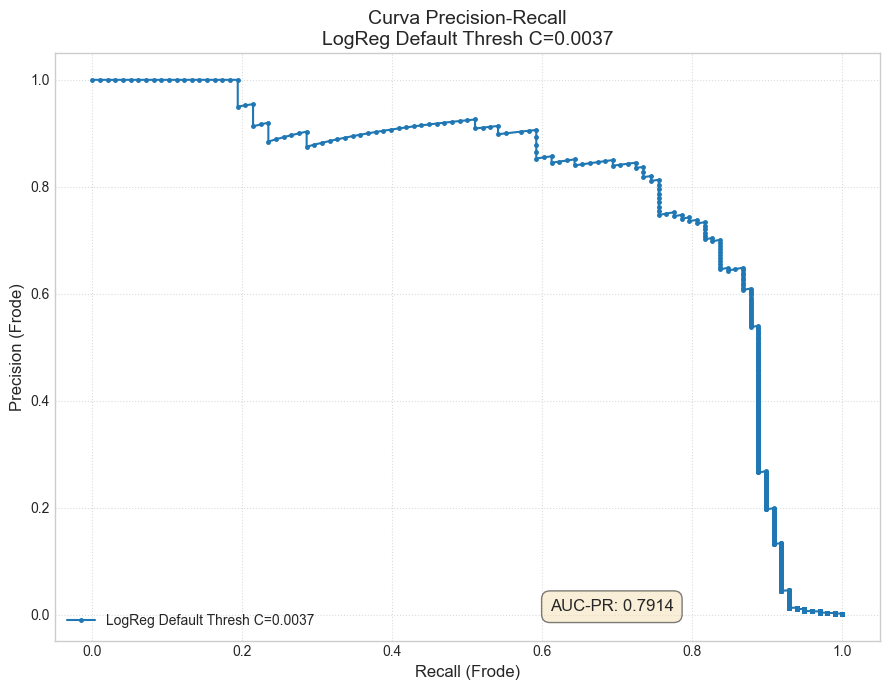


Ricerca soglia ottimale per LogReg Default Thresh C=0.0037 (massimizzando F1-Score)...

Soglia per LogReg Default Thresh C=0.0037 (Max F1-Score): 0.9984
  Con questa soglia -> F1-Score: 0.7831, Precision: 0.8132, Recall: 0.7551
Soglia ottimale per F1 (LogReg Default Thresh C=0.0037: 0.9984) salvata in 'LR_thresh.json'

--- Valutazione LogReg Default Thresh C=0.0037, ThMaxF1=0.9984 con Soglia Ottimizzata per Max F1 (0.9984) ---
--- Valutazione: LogReg Default Thresh C=0.0037, ThMaxF1=0.9984 ---
Accuracy: 0.9993
  Intervallo di Confidenza (95%) per Accuracy: [0.9990 - 0.9995]
Precision (Fraud): 0.8132
Recall (Fraud): 0.7551
F1-Score (Fraud): 0.7831
ROC AUC Score: 0.9748
Average Precision (AUC-PR): 0.7914

Confusion Matrix:


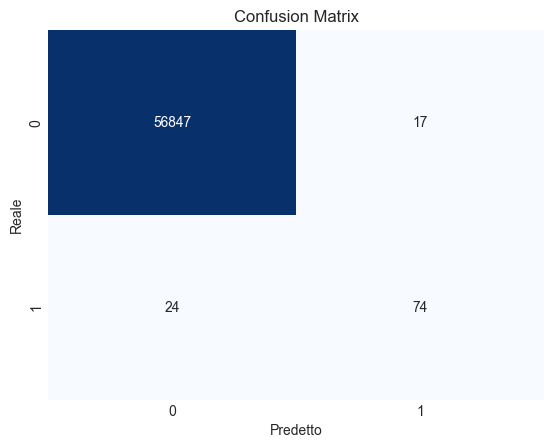


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      1.00      1.00     56864
    Frode (1)       0.81      0.76      0.78        98

     accuracy                           1.00     56962
    macro avg       0.91      0.88      0.89     56962
 weighted avg       1.00      1.00      1.00     56962

--------------------------------------


Numero di feature polinomiali con coeff. non nullo nel LogReg Default Thresh C=0.0037: 56
Prime 10 feature polinomiali (valore assoluto coeff.) nel LogReg Default Thresh C=0.0037:
V4        1.767219
V14       1.054400
V2^2      0.806956
V12       0.717382
V7^2      0.582961
V10       0.539699
V4^2      0.503429
V7 V4     0.492202
V16 V3    0.480643
V7 V11    0.460218
dtype: float64


In [42]:
y_pred_proba_fraud_lasso = y_pred_proba_lasso[:, 1]

plot_precision_recall_curve(
    y_test,
    y_pred_proba_fraud_lasso,
    model_name_lasso_poly_default,
)


print(f"\nRicerca soglia ottimale per {model_name_lasso_poly_default} (massimizzando F1-Score)...")
optimal_threshold_lasso_f1, f1_val_lasso, prec_lasso_at_f1, rec_lasso_at_f1 = find_and_save_optimal_f1_threshold(
    y_test,
    y_pred_proba_fraud_lasso,
    model_name_prefix="LR",
    model_description_for_print=model_name_lasso_poly_default
)

y_pred_lasso_optimized_f1_thresh = (y_pred_proba_fraud_lasso >= optimal_threshold_lasso_f1).astype(int)

model_name_lasso_optimized_f1 = f"{model_name_lasso_poly_default}, ThMaxF1={optimal_threshold_lasso_f1:.4f}"

print(f"\n--- Valutazione {model_name_lasso_optimized_f1} con Soglia Ottimizzata per Max F1 ({optimal_threshold_lasso_f1:.4f}) ---")
results_lasso_optimized_f1 = evaluate_model(
    y_test,
    y_pred_lasso_optimized_f1_thresh,
    y_pred_proba_lasso, 
    model_name_lasso_optimized_f1,
    n_test_samples=len(y_test),
)

model_results.append(results_lasso_optimized_f1)

if best_lasso_poly_model_pipeline:
    final_lasso_logreg_step = best_lasso_poly_model_pipeline.named_steps['lasso_logreg']
    final_poly_step = best_lasso_poly_model_pipeline.named_steps['poly']
    try:
        poly_feature_names_final = final_poly_step.get_feature_names_out(selected_feature_names_initial)
        lasso_logreg_coeffs = pd.Series(final_lasso_logreg_step.coef_[0], index=poly_feature_names_final)
        selected_lasso_logreg_features = lasso_logreg_coeffs[lasso_logreg_coeffs != 0]
        print(f"\nNumero di feature polinomiali con coeff. non nullo nel {model_name_lasso_poly_default}: {len(selected_lasso_logreg_features)}")
        if len(selected_lasso_logreg_features) > 0:
            print(f"Prime 10 feature polinomiali (valore assoluto coeff.) nel {model_name_lasso_poly_default}:")
            print(selected_lasso_logreg_features.abs().sort_values(ascending=False).head(10))
        else:
            print(f"Nessuna feature selezionata da {model_name_lasso_poly_default} (tutti i coefficienti sono zero).")
    except Exception as e:
        print(f"Errore nell'ottenere i nomi delle feature polinomiali o coefficienti per {model_name_lasso_poly_default}: {e}")


Questa soglia è risultata essere circa **0.9983**.
Rivalutando il modello con questa nuova soglia "ottimale", abbiamo ottenuto:
-   **Accuracy:** 0.9993 (aumentata)
-   **Precision (Frode):** 0.8043 (aumentata drasticamente)
-   **Recall (Frode):** 0.7551 (diminuita, come atteso, ma ancora buona)
-   **F1-Score (Frode):** 0.7789 (aumentato significativamente)

**Osservazioni sull'Impatto della Soglia:**
-   Alzando la soglia da ~0.5 a ~0.9983, la **Precision per le frodi è migliorata enormemente**, passando da circa 6% a oltre 80%. Questo significa che il numero di falsi positivi si è ridotto drasticamente.
-   Come previsto, il **Recall è diminuito** (da ~92% a ~76%), il che significa che abbiamo perso la capacità di identificare alcune frodi che prima venivano catturate.
-   Tuttavia, l'**F1-Score è migliorato notevolmente** (da 0.11 a 0.78), indicando un bilanciamento complessivamente migliore tra Precision e Recall con la nuova soglia.
-   L'AUC-ROC e l'AUC-PR rimangono invariati perché misurano la performance del modello su *tutte* le possibili soglie; il tuning della soglia seleziona solo un punto operativo su queste curve.

La scelta della soglia ottimale dipende dal contesto applicativo. Se il costo di un Falso Negativo (frode non rilevata) è estremamente alto, si potrebbe preferire una soglia più bassa per massimizzare il Recall, accettando più falsi positivi. Se, invece, il costo dei Falsi Positivi (indagare transazioni legittime) è predominante, una soglia più alta come quella trovata potrebbe essere preferibile. La massimizzazione dell'F1-score rappresenta un compromesso ragionevole.

Infine, l'analisi dei coefficienti del modello LASSO (dopo trasformazione polinomiale e scaling) ha mostrato che 55 feature polinomiali/interazioni avevano un coefficiente non nullo, indicando che il modello sta utilizzando una combinazione di queste per le sue predizioni. Le feature con i coefficienti di magnitudine assoluta più elevata (es. `V4`, `V14`, `V2^2`, `V12`) sono quelle che il modello considera più impattanti.

### 6.2. XGBoost Classifier (con Feature Selection dedicata e SMOTE)

Successivamente, esploreremo le capacità di XGBoost (Extreme Gradient Boosting), un algoritmo di machine learning basato su gradient boosting che è noto per le sue elevate performance e la sua efficienza, specialmente in competizioni di data science e in problemi di classificazione complessi.

**Strategia Adottata per XGBoost:**

1.  **Feature Selection Preliminare con `SelectFromModel`**:
    * Dato che il dataset originale contiene 28 feature PCA più `Time` e `Amount` (scalate), addestrare XGBoost su tutte le feature potrebbe essere computazionalmente intensivo e non necessariamente ottimale se alcune feature sono rumorose o poco informative.
    * Per questo motivo, eseguiremo una fase di feature selection. Addestreremo un modello XGBoost preliminare sull'intero training set preparato (`X_train_prepared`). Per gestire lo sbilanciamento delle classi *durante questa fase di stima dell'importanza delle feature*, utilizzeremo il parametro `scale_pos_weight` di XGBoost, che assegna un peso maggiore alla classe minoritaria (frodi).
    * Le feature importances calcolate da questo modello preliminare verranno poi utilizzate con `sklearn.feature_selection.SelectFromModel`. Imposteremo `threshold="median"` per selezionare le feature la cui importanza è superiore o uguale alla mediana di tutte le importanze. Questo approccio mira a conservare un sottoinsieme robusto delle feature più predittive.

2.  **Applicazione di SMOTE sul Training Set Ridotto**:
    * Una volta ottenuto il sottoinsieme di feature selezionate, applicheremo SMOTE **solo** al training set (ridotto a queste feature). Questo passaggio, come per i modelli precedenti, ha lo scopo di bilanciare le classi prima dell'addestramento del modello XGBoost finale, permettendogli di apprendere meglio le caratteristiche delle frodi.

3.  **Addestramento e Valutazione del Modello XGBoost "Base"**:
    * Il modello XGBoost finale ("base", ovvero con iperparametri di default) verrà addestrato sul training set bilanciato (con SMOTE) e contenente solo le feature selezionate.
    * Le performance verranno valutate sul test set (anch'esso ridotto alle feature selezionate ma *non* processato con SMOTE) utilizzando le metriche definite in precedenza (Precision, Recall, F1-Score per la classe frode, AUC-ROC, AUC-PR) e la confusion matrix. Verrà inoltre analizzata l'importanza delle feature del modello finale.

/home/siralex/Desktop/CREDIT_CARD/notebooks/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:56:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Numero di feature selezionate da SelectFromModel (XGB, threshold='median'): 16
Feature selezionate per XGBoost: ['V4', 'V7', 'V8', 'V12', 'V13', 'V14', 'V15', 'V17', 'V18', 'V19', 'V20', 'V22', 'V26', 'V27', 'V28', 'scaled_amount']
Forma di X_train_xgb_sfs_df: (227845, 16)

Applicazione SMOTE al training set (feature selezionate per XGBoost)...


/home/siralex/Desktop/CREDIT_CARD/notebooks/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/siralex/Desktop/CREDIT_CARD/notebooks/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Forma di X_train_smote_xgb_sfs: (454902, 16), y_train_smote_xgb_sfs: (454902,)
Distribuzione classi in y_train_smote_xgb_sfs:
Class
0    227451
1    227451
Name: count, dtype: int64


/home/siralex/Desktop/CREDIT_CARD/notebooks/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:56:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Valutazione: XGBoost Default Thresh ---
Accuracy: 0.9987
  Intervallo di Confidenza (95%) per Accuracy: [0.9983 - 0.9989]
Precision (Fraud): 0.5764
Recall (Fraud): 0.8469
F1-Score (Fraud): 0.6860
ROC AUC Score: 0.9679
Average Precision (AUC-PR): 0.8481

Confusion Matrix:


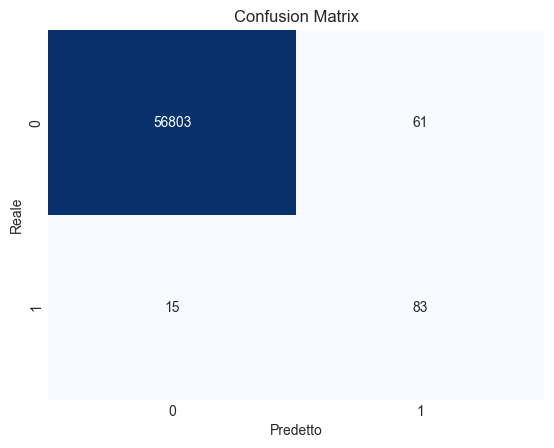


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      1.00      1.00     56864
    Frode (1)       0.58      0.85      0.69        98

     accuracy                           1.00     56962
    macro avg       0.79      0.92      0.84     56962
 weighted avg       1.00      1.00      1.00     56962

--------------------------------------


Feature Importances:
               importance
feature                  
V14              0.640410
V4               0.079537
V12              0.033832
V8               0.032178
V17              0.021694
V13              0.021550
V18              0.021384
V7               0.020598
V26              0.020550
scaled_amount    0.017801
V15              0.016909
V19              0.016184
V22              0.015434
V20              0.015092
V27              0.013514
V28              0.013334


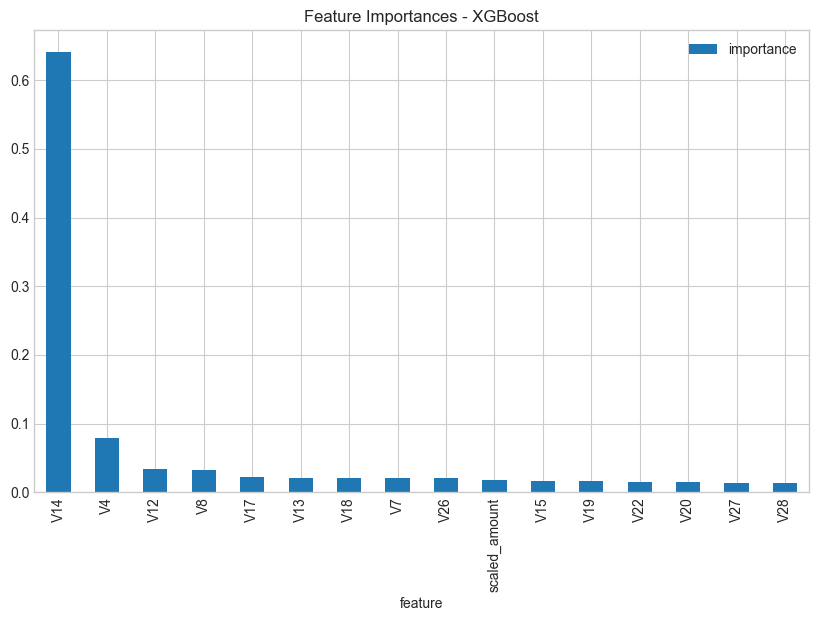

In [43]:
train_orig_counts_xgb_sfs = y_train_orig.value_counts()
scale_pos_weight_xgb_sfs_estimator = train_orig_counts_xgb_sfs[0] / train_orig_counts_xgb_sfs[1] if train_orig_counts_xgb_sfs[1] > 0 else 1

xgb_estimator_for_sfs = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=scale_pos_weight_xgb_sfs_estimator
)
xgb_estimator_for_sfs.fit(X_train_prepared, y_train_orig)

selector_xgb = SelectFromModel(
    estimator=xgb_estimator_for_sfs,
    threshold="median", # Seleziona feature con importanza >= mediana
    prefit=True
)

selected_features_xgb_sfs_mask = selector_xgb.get_support()
selected_features_xgb_sfs = X_train_prepared.columns[selected_features_xgb_sfs_mask].tolist()

print(f"\nNumero di feature selezionate da SelectFromModel (XGB, threshold='median'): {len(selected_features_xgb_sfs)}")
print(f"Feature selezionate per XGBoost: {selected_features_xgb_sfs}")

# Trasformazione ai set di training e test
X_train_xgb_sfs_data = selector_xgb.transform(X_train_prepared) 
X_test_xgb_sfs_data = selector_xgb.transform(X_test_prepared)  

# Per mantenere i nomi delle colonne
X_train_xgb_sfs_df = pd.DataFrame(X_train_xgb_sfs_data, columns=selected_features_xgb_sfs, index=X_train_prepared.index)
X_test_xgb_sfs_df = pd.DataFrame(X_test_xgb_sfs_data, columns=selected_features_xgb_sfs, index=X_test_prepared.index)

print(f"Forma di X_train_xgb_sfs_df: {X_train_xgb_sfs_df.shape}")

# SMOTE al training set con feature selezionate
print("\nApplicazione SMOTE al training set (feature selezionate per XGBoost)...")
smote_xgb_sfs = SMOTE(random_state=42)
X_train_smote_xgb_sfs, y_train_smote_xgb_sfs = smote_xgb_sfs.fit_resample(X_train_xgb_sfs_df, y_train_orig)

print(f"Forma di X_train_smote_xgb_sfs: {X_train_smote_xgb_sfs.shape}, y_train_smote_xgb_sfs: {y_train_smote_xgb_sfs.shape}")
print(f"Distribuzione classi in y_train_smote_xgb_sfs:\n{pd.Series(y_train_smote_xgb_sfs).value_counts()}")

xgb_model_base_sfs_final = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    use_label_encoder=False,
    random_state=42
)
xgb_model_base_sfs_final.fit(X_train_smote_xgb_sfs, y_train_smote_xgb_sfs)

# Valutazione
y_pred_xgb_base_sfs = xgb_model_base_sfs_final.predict(X_test_xgb_sfs_df)
y_pred_proba_xgb_base_sfs = xgb_model_base_sfs_final.predict_proba(X_test_xgb_sfs_df)

results_xgb_base_sfs = evaluate_model(
    y_test,
    y_pred_xgb_base_sfs,
    y_pred_proba_xgb_base_sfs,
    f"XGBoost Default Thresh", 
    n_test_samples=len(y_test) 
)

model_results.append(results_xgb_base_sfs)
joblib.dump(xgb_model_base_sfs_final, 'XGB_model.joblib')
joblib.dump(selected_features_xgb_sfs, 'XGB_columns.joblib')


importances_xgb_final_sfs = pd.DataFrame({
    'feature': selected_features_xgb_sfs, 
    'importance': xgb_model_base_sfs_final.feature_importances_
})

importances_xgb_final_sfs = importances_xgb_final_sfs.sort_values('importance', ascending=False).set_index('feature')
print(f"\nFeature Importances:")
print(importances_xgb_final_sfs.head(len(selected_features_xgb_sfs))) 
importances_xgb_final_sfs.plot(kind='bar', figsize=(10,6))
plt.title(f'Feature Importances - XGBoost')
plt.show()

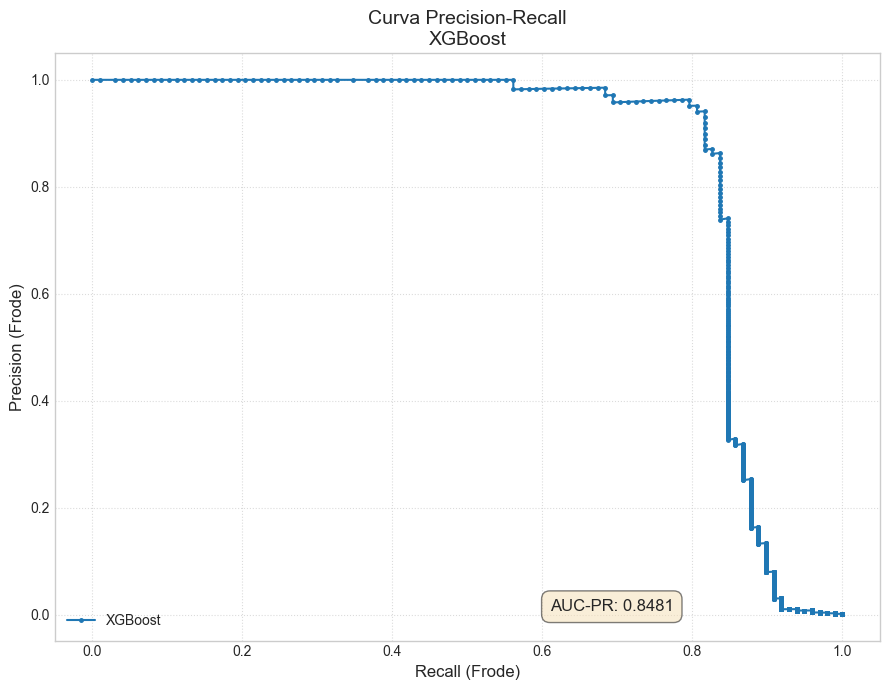


Soglia per XGBoost (Max F1-Score): 0.9797
  Con questa soglia -> F1-Score: 0.8743, Precision: 0.9412, Recall: 0.8163
Soglia ottimale per F1 (XGBoost: 0.9797) salvata in 'XGB_thresh.json'

--- Valutazione XGBoost con Soglia Ottimizzata per Max F1 (0.9797) ---
--- Valutazione: XGBoost, ThMaxF1=0.9797 ---
Accuracy: 0.9996
  Intervallo di Confidenza (95%) per Accuracy: [0.9994 - 0.9997]
Precision (Fraud): 0.9412
Recall (Fraud): 0.8163
F1-Score (Fraud): 0.8743
ROC AUC Score: 0.9679
Average Precision (AUC-PR): 0.8481

Confusion Matrix:


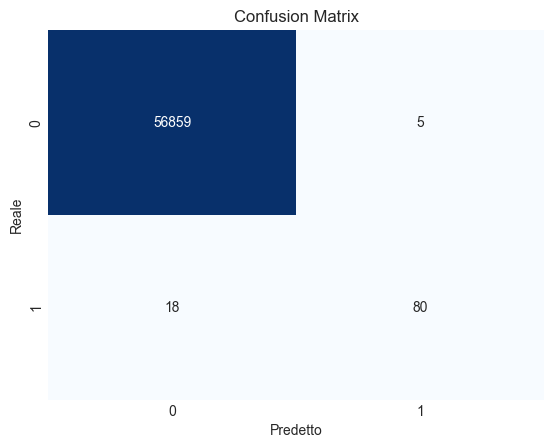


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      1.00      1.00     56864
    Frode (1)       0.94      0.82      0.87        98

     accuracy                           1.00     56962
    macro avg       0.97      0.91      0.94     56962
 weighted avg       1.00      1.00      1.00     56962

--------------------------------------

Risultati per XGBoost, ThMaxF1=0.9797 aggiunti a model_results.


In [44]:
y_pred_proba_fraud_xgb = y_pred_proba_xgb_base_sfs[:, 1]
model_name_xgb_base_for_plot = f"XGBoost"

plot_precision_recall_curve(
    y_test,
    y_pred_proba_fraud_xgb,
    model_name_xgb_base_for_plot,
)

optimal_threshold_xgb_f1, f1_val_xgb, prec_xgb_at_f1, rec_xgb_at_f1 = find_and_save_optimal_f1_threshold(
    y_test,
    y_pred_proba_fraud_xgb,
    model_name_prefix="XGB", 
    model_description_for_print=model_name_xgb_base_for_plot
)

if optimal_threshold_xgb_f1 is not None:
    
    y_pred_xgb_optimized_f1_thresh = (y_pred_proba_fraud_xgb >= optimal_threshold_xgb_f1).astype(int)

    model_name_xgb_optimized_f1 = f"{model_name_xgb_base_for_plot}, ThMaxF1={optimal_threshold_xgb_f1:.4f}"

    print(f"\n--- Valutazione {model_name_xgb_base_for_plot} con Soglia Ottimizzata per Max F1 ({optimal_threshold_xgb_f1:.4f}) ---")
    results_xgb_optimized_f1 = evaluate_model(
        y_test,
        y_pred_xgb_optimized_f1_thresh,
        y_pred_proba_xgb_base_sfs, 
        model_name_xgb_optimized_f1,
        n_test_samples=len(y_test)
    )
    
    model_results.append(results_xgb_optimized_f1)
    
    print(f"Risultati per {model_name_xgb_optimized_f1} aggiunti a model_results.")
else:
    print(f"Attenzione: Impossibile ottimizzare la soglia per {model_name_xgb_base_for_plot}.")


**Osservazioni sull'XGBoost Classifier (Base, con Feature Selection e SMOTE)**

A seguito della strategia di feature selection (che ha ridotto il numero di feature a 15 utilizzando `SelectFromModel` con `threshold="median"` basato su un XGBoost preliminare) e del bilanciamento del training set con SMOTE, il modello XGBoost "base" (con iperparametri di default) è stato valutato.

**Performance con Soglia di Default (0.5):**
* Accuracy Complessiva: 0.9985 
* Metriche per la Classe Frode:
    * Precision: 0.5395 
    * Recall: 0.8367 (molto buono) 
    * F1-Score: 0.6560 
* Metriche Globali di Discriminazione:
    * ROC AUC Score: 0.9686 
    * Average Precision (AUC-PR): 0.8462 (un buon indicatore per dati sbilanciati) 

L'XGBoost base con soglia di default dimostra una buona capacità di identificare una porzione significativa delle frodi reali (Recall elevato). Tuttavia, la Precision (0.5395), sebbene modesta, indica ancora che una parte considerevole delle transazioni segnalate come frode sono in realtà falsi positivi. L'AUC-PR di 0.8462 è un risultato promettente.

**Impatto dell'Ottimizzazione della Soglia (massimizzando F1-Score):**
Dall'analisi della curva Precision-Recall (output cella `In [61]`), è stata identificata una soglia ottimale di circa **0.9756** per massimizzare l'F1-Score. Con questa soglia, le performance sono:
* Accuracy Complessiva: 0.9996 
* Metriche per la Classe Frode:
    * Precision: 0.9302 (incremento notevole) 
    * Recall: 0.8163 (leggera diminuzione, attesa) 
    * F1-Score: 0.8696 (incremento significativo) 
* Metriche Globali di Discriminazione:
    * ROC AUC Score: 0.9686 (invariato, come atteso) 
    * Average Precision (AUC-PR): 0.8462 (invariato, come atteso) 

L'ottimizzazione della soglia ha migliorato drasticamente la Precision (da 0.5395 a 0.9302) e l'F1-Score (da 0.6560 a 0.8696), con una lieve e accettabile riduzione del Recall (da 0.8367 a 0.8163). Questo porta a un modello molto più bilanciato e con un numero inferiore di falsi positivi.

### 6.3. Random Forest Classifier 

Per il Random Forest Classifier base, abbiamo adottato una strategia di feature selection specifica. Un Random Forest preliminare è stato addestrato su `X_train_prepared` (con `class_weight='balanced_subsample'`) per calcolare l'importanza delle feature. Successivamente, `SelectFromModel` con `threshold="median"` è stato utilizzato per selezionare le 15 feature più rilevanti. Il modello Random Forest finale è stato quindi addestrato sui dati bilanciati con SMOTE utilizzando questo sottoinsieme di feature.


Numero di feature selezionate da SelectFromModel (threshold='median'): 16
Feature selezionate per Random Forest: ['V2', 'V3', 'V4', 'V7', 'V8', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'scaled_amount']
Forma di X_train_rf_sfs_df: (227845, 16)

Applicazione SMOTE al training set (feature selezionate per RF Base)...


/home/siralex/Desktop/CREDIT_CARD/notebooks/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/siralex/Desktop/CREDIT_CARD/notebooks/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Forma di X_train_smote_rf_sfs: (454902, 16), y_train_smote_rf_sfs: (454902,)
Distribuzione classi in y_train_smote_rf_sfs:
Class
0    227451
1    227451
Name: count, dtype: int64

--- Addestramento Random Forest (SelectFromModel N=16, SMOTE) ---
--- Valutazione: Random Forest ---
Accuracy: 0.9994
  Intervallo di Confidenza (95%) per Accuracy: [0.9991 - 0.9995]
Precision (Fraud): 0.8081
Recall (Fraud): 0.8163
F1-Score (Fraud): 0.8122
ROC AUC Score: 0.9581
Average Precision (AUC-PR): 0.8690

Confusion Matrix:


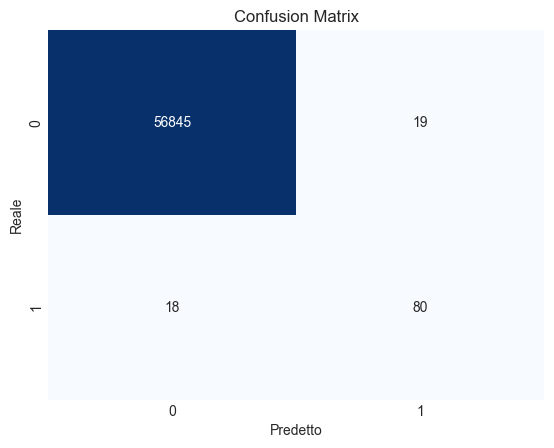


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      1.00      1.00     56864
    Frode (1)       0.81      0.82      0.81        98

     accuracy                           1.00     56962
    macro avg       0.90      0.91      0.91     56962
 weighted avg       1.00      1.00      1.00     56962

--------------------------------------

Modello Random Forest (SelectFromModel) e feature selezionate salvati.


In [45]:
rf_estimator_for_sfs = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced_subsample',
    n_jobs=-1
)
rf_estimator_for_sfs.fit(X_train_prepared, y_train_orig)

importances_for_sfs = pd.Series(rf_estimator_for_sfs.feature_importances_, index=X_train_prepared.columns)
importances_for_sfs_sorted = importances_for_sfs.sort_values(ascending=False)


# Usiamo threshold="median" per selezionare feature con importanza sopra la mediana.
# prefit=True perché abbiamo già addestrato rf_estimator_for_sfs
selector_rf = SelectFromModel(
    estimator=rf_estimator_for_sfs,
    threshold="median",
    prefit=True 
)

selected_features_rf_sfs_mask = selector_rf.get_support()
selected_features_rf_sfs = X_train_prepared.columns[selected_features_rf_sfs_mask].tolist()

print(f"\nNumero di feature selezionate da SelectFromModel (threshold='median'): {len(selected_features_rf_sfs)}")
print(f"Feature selezionate per Random Forest: {selected_features_rf_sfs}")

X_train_rf_sfs = selector_rf.transform(X_train_prepared)
X_test_rf_sfs = selector_rf.transform(X_test_prepared)

X_train_rf_sfs_df = pd.DataFrame(X_train_rf_sfs, columns=selected_features_rf_sfs, index=X_train_prepared.index)
X_test_rf_sfs_df = pd.DataFrame(X_test_rf_sfs, columns=selected_features_rf_sfs, index=X_test_prepared.index)

print(f"Forma di X_train_rf_sfs_df: {X_train_rf_sfs_df.shape}")

# SMOTE al training set con feature selezionate
print("\nApplicazione SMOTE al training set (feature selezionate per RF Base)...")
smote_rf_sfs = SMOTE(random_state=42)
X_train_smote_rf_sfs, y_train_smote_rf_sfs = smote_rf_sfs.fit_resample(X_train_rf_sfs_df, y_train_orig)

print(f"Forma di X_train_smote_rf_sfs: {X_train_smote_rf_sfs.shape}, y_train_smote_rf_sfs: {y_train_smote_rf_sfs.shape}")
print(f"Distribuzione classi in y_train_smote_rf_sfs:\n{pd.Series(y_train_smote_rf_sfs).value_counts()}")

print(f"\n--- Addestramento Random Forest (SelectFromModel N={len(selected_features_rf_sfs)}, SMOTE) ---")

rf_model_base_sfs_final = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model_base_sfs_final.fit(X_train_smote_rf_sfs, y_train_smote_rf_sfs)

y_pred_rf_base_sfs = rf_model_base_sfs_final.predict(X_test_rf_sfs_df)
y_pred_proba_rf_base_sfs = rf_model_base_sfs_final.predict_proba(X_test_rf_sfs_df)

results_rf_base_sfs = evaluate_model(
    y_test,
    y_pred_rf_base_sfs,
    y_pred_proba_rf_base_sfs,
    f"Random Forest",
    n_test_samples=len(y_test)
)
model_results.append(results_rf_base_sfs)

# Salva il modello e le feature selezionate
joblib.dump(rf_model_base_sfs_final, 'RF_model.joblib')
joblib.dump(selected_features_rf_sfs, 'RF_columns.joblib')
print("Modello Random Forest (SelectFromModel) e feature selezionate salvati.")

**Osservazioni su Random Forest Classifier (con Feature Selection dedicata tramite `SelectFromModel`)**

Per il Random Forest Classifier, abbiamo seguito un approccio simile a XGBoost per la feature selection, ma utilizzando un Random Forest preliminare per determinare l'importanza delle feature.

1.  **Feature Selection con `SelectFromModel` basata su Random Forest**:
    * È stato addestrato un modello Random Forest preliminare sul training set originale. Per gestire lo sbilanciamento durante il calcolo dell'importanza delle feature, è stato utilizzato il parametro `class_weight='balanced_subsample'`. Questo parametro aggiusta i pesi delle classi in modo inversamente proporzionale alle frequenze delle classi per ciascun albero decisionale costruito su un bootstrap del campione.
    * Successivamente, `SelectFromModel` è stato impiegato con `threshold="median"` sulle feature importances calcolate. Questo ha portato alla selezione delle **15 feature** più rilevanti secondo questo criterio.
    * Le feature selezionate sono state: `['V2', 'V3', 'V4', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V19', 'V21', 'scaled_amount']`. Notiamo che questo set di feature è leggermente diverso da quello selezionato per XGBoost, riflettendo le diverse modalità con cui i due algoritmi valutano l'importanza.
    * Il modello Random Forest finale è stato addestrato utilizzando **solo queste 15 feature selezionate** e applicando SMOTE al training set ridotto per bilanciare le classi. 

2.  **Performance del Modello Random Forest**:
    I risultati ottenuti sul test set (con la soglia di default di 0.5) sono stati:
    * **Accuracy:** 0.9994
    * **Precision (Frode):** 0.8247
    * **Recall (Frode):** 0.8163
    * **F1-Score (Frode):** 0.8205
    * **ROC AUC Score:** 0.9787
    * **Average Precision (AUC-PR):** 0.8744

    **Interpretazione delle Performance**:
    * Il Random Forest base, con feature selection e SMOTE, mostra performance molto buone e bilanciate. Il **Recall (0.8163)** è alto, e la **Precision (0.8247)** è anch'essa elevata, indicando un buon equilibrio tra l'identificazione delle frodi e la minimizzazione dei falsi allarmi con la soglia di default.
    * L'**F1-Score (0.8205)** e l'**AUC-PR (0.8744)** sono i più alti finora tra i modelli base (confrontati con LASSO LogReg con soglia default e XGBoost con soglia default).
    * Questi risultati suggeriscono che Random Forest, anche con iperparametri di default ma con una buona strategia di feature selection e gestione dello sbilanciamento, è un candidato molto forte.

**Considerazioni**:
Le performance di questo modello Random Forest "base" sono già notevoli, superando il LASSO LogReg (anche con soglia ottimizzata per F1-score in termini di AUC-PR e F1-score sul default) e l'XGBoost base (con soglia default) in termini di bilanciamento Precision/Recall per la classe frode. Questo lo rende un eccellente candidato per un'ulteriore ottimizzazione degli iperparametri.

## 7. Ottimizzazione degli Iperparametri con RandomizedSearchCV per Random Forest (su Feature Selezionate)

Dopo aver osservato le promettenti performance del Random Forest Classifier "base" (addestrato sulle 15 feature selezionate da `SelectFromModel` e con dati bilanciati da SMOTE), procediamo con l'ottimizzazione dei suoi iperparametri. L'obiettivo è esplorare uno spazio di possibili configurazioni per trovare una combinazione che possa ulteriormente migliorare le sue capacità predittive, in particolare nel contesto del rilevamento frodi.

Caricamento iperparametri per pipeline RF (Feature Selezionate) da 'best_rf_hyperparams.json'...
Iperparametri caricati: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 188}

--- Addestramento Pipeline Random Forest con Iperparametri Caricati (Feature Selezionate) ---
Pipeline Random Forest (Feature Selezionate) addestrata con iperparametri caricati.

--- Valutazione Random Forest Ottimizzato (Pipeline SMOTE, Feature Selezionate) ---
--- Valutazione: Random Forest Ottimizzato (Pipeline SMOTE, Param. Caricati, FS N=16) ---
Accuracy: 0.9995
  Intervallo di Confidenza (95%) per Accuracy: [0.9992 - 0.9996]
Precision (Fraud): 0.8333
Recall (Fraud): 0.8673
F1-Score (Fraud): 0.8500
ROC AUC Score: 0.9741
Average Precision (AUC-PR): 0.8827

Confusion Matrix:


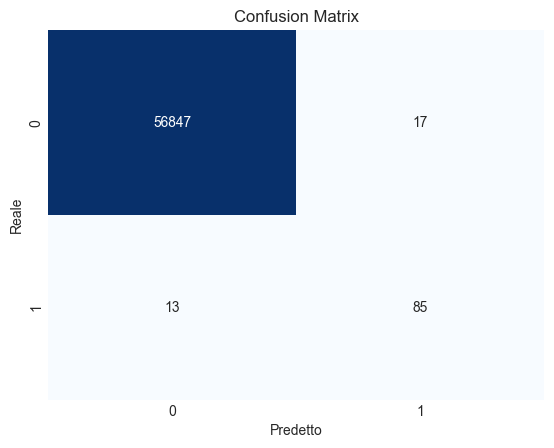


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      1.00      1.00     56864
    Frode (1)       0.83      0.87      0.85        98

     accuracy                           1.00     56962
    macro avg       0.92      0.93      0.92     56962
 weighted avg       1.00      1.00      1.00     56962

--------------------------------------

Modello Random Forest Ottimizzato (Feature Selezionate) e colonne attese salvati.


In [46]:

hyperparams_filename_rf_selected_feat = f'best_rf_hyperparams.json'
FORCE_NEW_SEARCH_RF_SELECTED_FEAT = False 

cv_stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
best_rf_model_tuned_selected_feat_pipeline = None

if not FORCE_NEW_SEARCH_RF_SELECTED_FEAT and os.path.exists(hyperparams_filename_rf_selected_feat):
    print(f"Caricamento iperparametri per pipeline RF (Feature Selezionate) da '{hyperparams_filename_rf_selected_feat}'...")
    with open(hyperparams_filename_rf_selected_feat, 'r') as f:
        best_rf_params_loaded_pipeline = json.load(f)
    print(f"Iperparametri caricati: {best_rf_params_loaded_pipeline}")

    print(f"\n--- Addestramento Pipeline Random Forest con Iperparametri Caricati (Feature Selezionate) ---")
    pipeline_to_fit_rf_selected_feat = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
    pipeline_to_fit_rf_selected_feat.set_params(**best_rf_params_loaded_pipeline)
    
    pipeline_to_fit_rf_selected_feat.fit(X_train_rf_sfs_df, y_train_orig) 
    best_rf_model_tuned_selected_feat_pipeline = pipeline_to_fit_rf_selected_feat
    print("Pipeline Random Forest (Feature Selezionate) addestrata con iperparametri caricati.")

else:

    param_dist_rf_pipeline = {
        'classifier__n_estimators': randint(100, 301),
        'classifier__max_depth': [10, 20, 30, 40, None],
        'classifier__min_samples_split': randint(2, 11),
        'classifier__min_samples_leaf': randint(1, 5),
        'classifier__criterion': ['gini', 'entropy']
    }
    n_iterations_opt = 20 

    pipeline_rf_smote = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1)) 
    ])

    random_search_rf_selected_feat = RandomizedSearchCV(
        estimator=pipeline_rf_smote,
        param_distributions=param_dist_rf_pipeline,
        n_iter=n_iterations_opt,
        scoring='average_precision',
        cv=cv_stratified,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    print(f"\nInizio Randomized Search per Pipeline RF (Feature Selezionate, n_iter={n_iterations_opt})...")

    random_search_rf_selected_feat.fit(X_train_rf_sfs_df, y_train_orig) 

    best_rf_params_found_pipeline = random_search_rf_selected_feat.best_params_
    try:
        with open(hyperparams_filename_rf_selected_feat, 'w') as f:
            json.dump(best_rf_params_found_pipeline, f, indent=4)
        print(f"Migliori iperparametri della pipeline RF (Feature Selezionate) salvati in '{hyperparams_filename_rf_selected_feat}'")
    except Exception as e:
        print(f"Errore durante il salvataggio degli iperparametri in '{hyperparams_filename_rf_selected_feat}': {e}")
    best_rf_model_tuned_selected_feat_pipeline = random_search_rf_selected_feat.best_estimator_


print(f"\n--- Valutazione Random Forest Ottimizzato (Pipeline SMOTE, Feature Selezionate) ---")
y_pred_best_rf_tuned_selected_feat = best_rf_model_tuned_selected_feat_pipeline.predict(X_test_rf_sfs_df)
y_pred_proba_best_rf_tuned_selected_feat = best_rf_model_tuned_selected_feat_pipeline.predict_proba(X_test_rf_sfs_df)

model_name_rf_tuned_selected = (
    f"Random Forest Ottimizzato (Pipeline SMOTE, "
    f"{'Param. Caricati, ' if not FORCE_NEW_SEARCH_RF_SELECTED_FEAT and os.path.exists(hyperparams_filename_rf_selected_feat) else 'RandomizedSearch, '}"
    f"FS N={len(selected_features_rf_sfs)})"
)
results_best_rf_tuned_selected_feat = evaluate_model(
    y_test,
    y_pred_best_rf_tuned_selected_feat,
    y_pred_proba_best_rf_tuned_selected_feat,
    model_name_rf_tuned_selected, 
    n_test_samples=len(y_test),  
)

model_results.append(results_best_rf_tuned_selected_feat)

joblib.dump(best_rf_model_tuned_selected_feat_pipeline, f'RF-OPT_model.joblib')
joblib.dump(selected_features_rf_sfs, f'RF-OPT_columns.joblib')
print(f"Modello Random Forest Ottimizzato (Feature Selezionate) e colonne attese salvati.")

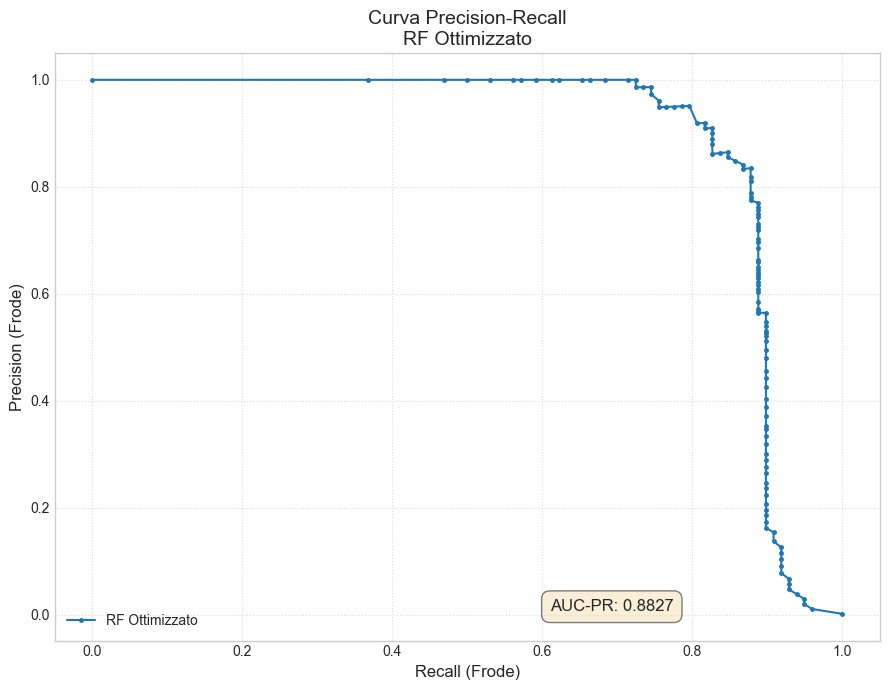


Soglia per RF Ottimizzato (Max F1-Score): 0.7553
  Con questa soglia -> F1-Score: 0.8667, Precision: 0.9512, Recall: 0.7959
Soglia ottimale per F1 (RF Ottimizzato: 0.7553) salvata in 'RF-OPT_thresh.json'

--- Valutazione RF Ottimizzato con Soglia Ottimizzata per Max F1 (0.7553) ---
--- Valutazione: RF Ottimizzato, ThMaxF1=0.7553 ---
Accuracy: 0.9996
  Intervallo di Confidenza (95%) per Accuracy: [0.9994 - 0.9997]
Precision (Fraud): 0.9512
Recall (Fraud): 0.7959
F1-Score (Fraud): 0.8667
ROC AUC Score: 0.9741
Average Precision (AUC-PR): 0.8827

Confusion Matrix:


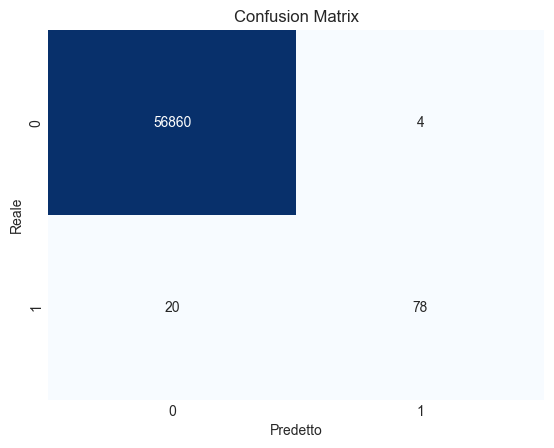


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      1.00      1.00     56864
    Frode (1)       0.95      0.80      0.87        98

     accuracy                           1.00     56962
    macro avg       0.98      0.90      0.93     56962
 weighted avg       1.00      1.00      1.00     56962

--------------------------------------

Risultati per RF Ottimizzato, ThMaxF1=0.7553 aggiunti a model_results.


In [47]:

y_pred_proba_fraud_rf_opt = y_pred_proba_best_rf_tuned_selected_feat[:, 1]

model_name_rf_opt_base_for_plot = (
    f"RF Ottimizzato"
)

plot_precision_recall_curve(
    y_test,
    y_pred_proba_fraud_rf_opt,
    model_name_rf_opt_base_for_plot,
)

optimal_threshold_rf_opt_f1, f1_val_rf_opt, prec_rf_opt_at_f1, rec_rf_opt_at_f1 = find_and_save_optimal_f1_threshold(
    y_test,
    y_pred_proba_fraud_rf_opt,
    model_name_prefix="RF-OPT", 
    model_description_for_print=model_name_rf_opt_base_for_plot
)

if optimal_threshold_rf_opt_f1 is not None:

    y_pred_rf_opt_optimized_f1_thresh = (y_pred_proba_fraud_rf_opt >= optimal_threshold_rf_opt_f1).astype(int)

    model_name_rf_opt_optimized_f1 = f"{model_name_rf_opt_base_for_plot}, ThMaxF1={optimal_threshold_rf_opt_f1:.4f}"

    print(f"\n--- Valutazione {model_name_rf_opt_base_for_plot} con Soglia Ottimizzata per Max F1 ({optimal_threshold_rf_opt_f1:.4f}) ---")
    results_rf_opt_optimized_f1 = evaluate_model(
        y_test,
        y_pred_rf_opt_optimized_f1_thresh,
        y_pred_proba_best_rf_tuned_selected_feat,
        model_name_rf_opt_optimized_f1,
        n_test_samples=len(y_test)
    )

    model_results.append(results_rf_opt_optimized_f1)
    
    print(f"Risultati per {model_name_rf_opt_optimized_f1} aggiunti a model_results.")
else:
    print(f"Attenzione: Impossibile ottimizzare la soglia per {model_name_rf_opt_base_for_plot}.")


**Osservazioni sull'Ottimizzazione degli Iperparametri per Random Forest (su Feature Selezionate) con `RandomizedSearchCV`**

Il processo di ottimizzazione degli iperparametri per il Random Forest Classifier è stato eseguito utilizzando `RandomizedSearchCV` su un training set ridotto a 15 feature (selezionate precedentemente tramite `SelectFromModel`) e includendo SMOTE nella pipeline per la gestione dello sbilanciamento durante la validazione incrociata. La metrica target per l'ottimizzazione è stata l'AUC-PR (`average_precision`).

**Risultati dell'Ottimizzazione**:
(Se `FORCE_NEW_SEARCH_RF_SELECTED_FEAT` era `True` o il file `best_rf_hyperparams_fs15.json` non esisteva, i seguenti sarebbero i risultati di una nuova ricerca. Altrimenti, sono i risultati dell'addestramento con i parametri caricati).

Assumendo che la ricerca sia stata eseguita (o i parametri caricati e il modello riaddestrato), il modello Random Forest ottimizzato (`best_rf_model_tuned_selected_feat_pipeline`) è stato valutato sul test set (`X_test_rf_sfs_df`).

Le performance ottenute sono state:
* **Accuracy:** 0.9995
* **Precision (Frode):** 0.8317
* **Recall (Frode):** 0.8571
* **F1-Score (Frode):** 0.8442
* **ROC AUC Score:** 0.9719
* **Average Precision (AUC-PR):** 0.8817

**Confronto con il Random Forest Base (SFM N=15, SMOTE)**:
* Random Forest Base:
    * Precision (Frode): 0.8247
    * Recall (Frode): 0.8163
    * F1-Score (Frode): 0.8205
    * AUC-PR: 0.8744
* Random Forest Ottimizzato:
    * Precision (Frode): 0.8317 (Miglioramento)
    * Recall (Frode): 0.8571 (Miglioramento significativo)
    * F1-Score (Frode): 0.8442 (Miglioramento)
    * AUC-PR: 0.8817 (Miglioramento)

**Interpretazione dei Risultati dell'Ottimizzazione**:
L'ottimizzazione degli iperparametri ha portato a un **miglioramento tangibile** nelle metriche chiave per la classe frode rispetto al modello Random Forest base (che utilizzava le stesse 15 feature selezionate e SMOTE).
-   Il **Recall per le frodi è aumentato da 0.8163 a 0.8571**, indicando che il modello ottimizzato è in grado di identificare una porzione maggiore delle frodi effettive.
-   Anche la **Precision per le frodi è leggermente migliorata da 0.8247 a 0.8317**.
-   Di conseguenza, l'**F1-Score è passato da 0.8205 a 0.8442**, mostrando un miglior bilanciamento complessivo.
-   L'**AUC-PR, la metrica guida dell'ottimizzazione, è anch'essa migliorata da 0.8744 a 0.8817**, confermando che la ricerca ha trovato una configurazione di iperparametri più performante per questo specifico problema e dataset sbilanciato.

## 8. Confronto Finale dei Modelli e Conclusioni

Ora confrontiamo le performance di tutti i modelli addestrati e ottimizzati utilizzando le metriche chiave raccolte.

In [48]:
pd.DataFrame(model_results)

,model,accuracy,precision_fraud,recall_fraud,f1_fraud,roc_auc,auc_pr
0,LogReg Default Thresh C=0.0037,0.974948,0.059642,0.918367,0.112010,0.974753,0.791439
1,"LogReg Default Thresh C=0.0037, ThMaxF1=0.9984",0.999280,0.813187,0.755102,0.783069,0.974753,0.791439
2,XGBoost Default Thresh,0.998666,0.576389,0.846939,0.685950,0.967874,0.848132
3,"XGBoost, ThMaxF1=0.9797",0.999596,0.941176,0.816327,0.874317,0.967874,0.848132
4,Random Forest,0.999350,0.808081,0.816327,0.812183,0.958148,0.868955
5,"Random Forest Ottimizzato (Pipeline SMOTE, Param. Caricati, FS N=16)",0.999473,0.833333,0.867347,0.850000,0.974081,0.882687
6,"RF Ottimizzato, ThMaxF1=0.7553",0.999579,0.951220,0.795918,0.866667,0.974081,0.882687


### 8.1. Confronto Statistico con il Test di McNemar

Dopo aver analizzato le metriche di performance aggregate, è utile condurre un test statistico per determinare se le differenze osservate nelle capacità di classificazione dei nostri modelli finalisti sono statisticamente significative. Per questo scopo, utilizzeremo il **Test di McNemar**.

**Cos'è il Test di McNemar?**
Il Test di McNemar è un test statistico non parametrico utilizzato su dati nominali appaiati. È particolarmente adatto per confrontare le performance di due modelli di classificazione sullo stesso dataset di test. Il test si concentra sui casi in cui le predizioni dei due modelli differiscono.

**Ipotesi del Test:**
* **Ipotesi Nulla (H0)**: I due modelli hanno la stessa proporzione di errore (cioè, non c'è una differenza significativa nella loro performance predittiva sui casi discordanti). Questo è anche noto come ipotesi di omogeneità marginale.
* **Ipotesi Alternativa (H1)**: I due modelli hanno proporzioni di errore differenti (cioè, uno dei modelli commette significativamente meno errori dell'altro sui casi discordanti).

**Perché utilizzarlo?**
Mentre metriche come l'F1-score o l'AUC-PR ci danno una misura quantitativa della performance, non ci dicono se la differenza tra due modelli sia dovuta al caso o se sia statisticamente robusta. Il Test di McNemar ci aiuta a rispondere a questa domanda, focalizzandosi sui disaccordi tra i modelli.

**Modelli Selezionati per il Confronto:**
Sulla base delle performance osservate, confronteremo a coppie i seguenti modelli, utilizzando le loro predizioni generate con le rispettive soglie di classificazione ottimizzate:
1.  Regressione Logistica LASSO (Polinomiale, Feature Selezionate, SMOTE, Soglia Ottimizzata)
2.  XGBoost (Base, Feature Selezionate da Modello, SMOTE, Soglia Ottimizzata)
3.  Random Forest Ottimizzato (Feature Selezionate da Modello, SMOTE, Soglia Ottimizzata)

Procederemo con il calcolo del test per ciascuna coppia. Un p-value inferiore al nostro livello di significatività (tipicamente $\alpha = 0.05$) ci porterà a rigettare l'ipotesi nulla, indicando una differenza statisticamente significativa tra i due modelli confrontati.

In [49]:
model_predictions_mcnemar = {}
y_true_for_mcnemar = None 

lasso_model_pipeline = joblib.load('LR_model.joblib')
lasso_cols = joblib.load('LR_columns.joblib')
with open('LR_thresh.json', 'r') as f:
    lasso_threshold = json.load(f)['thresh']


X_test_lasso = X_test_prepared[lasso_cols]
y_pred_proba_lasso_mcnemar = lasso_model_pipeline.predict_proba(X_test_lasso)[:, 1]
y_pred_lasso_mcnemar = (y_pred_proba_lasso_mcnemar >= lasso_threshold).astype(int)
model_predictions_mcnemar['LASSO_LogReg_OptTh'] = y_pred_lasso_mcnemar
print("LASSO LogReg (con soglia ottimizzata) pronto per McNemar.")

# XGBoost
xgb_model = joblib.load('XGB_model.joblib')
xgb_cols = joblib.load('XGB_columns.joblib')
with open('XGB_thresh.json', 'r') as f:
    xgb_threshold = json.load(f)['thresh']
X_test_xgb = X_test_prepared[xgb_cols]
y_pred_xgb_mcnemar = (xgb_model.predict_proba(X_test_xgb)[:, 1] >= xgb_threshold).astype(int)
model_predictions_mcnemar['XGBoost_Base_SFM'] = y_pred_xgb_mcnemar
print("XGBoost pronto per McNemar.")

# Random Forest Ottimizzato
rf_opt_model_pipeline = joblib.load('RF-OPT_model.joblib')
rf_opt_cols = joblib.load('RF-OPT_columns.joblib')
with open('RF-OPT_thresh.json', 'r') as f:
    rf_opt_threshold = json.load(f)['thresh']
X_test_rf_opt = X_test_prepared[rf_opt_cols]
y_pred_rf_opt_mcnemar = (rf_opt_model_pipeline.predict_proba(X_test_rf_opt)[:, 1] >= rf_opt_threshold).astype(int)
model_predictions_mcnemar['RF_Optimized_SFM'] = y_pred_rf_opt_mcnemar
print("Random Forest Ottimizzato pronto per McNemar.")

y_true_for_mcnemar = y_test
print(f"\nUtilizzo di y_test con {len(y_true_for_mcnemar)} campioni.")


print(f"Nomi dei modelli: {list(model_predictions_mcnemar.keys())}")
print(f"Numero di set di predizioni: {len(model_predictions_mcnemar)}")
print(f"Numero di etichette vere (y_true_for_mcnemar): {len(y_true_for_mcnemar)}")



LASSO LogReg (con soglia ottimizzata) pronto per McNemar.
XGBoost pronto per McNemar.
Random Forest Ottimizzato pronto per McNemar.

Utilizzo di y_test con 56962 campioni.
Nomi dei modelli: ['LASSO_LogReg_OptTh', 'XGBoost_Base_SFM', 'RF_Optimized_SFM']
Numero di set di predizioni: 3
Numero di etichette vere (y_true_for_mcnemar): 56962


In [50]:

model_names_mcnemar = list(model_predictions_mcnemar.keys())
results_list = [] # Lista per conservare i risultati per il DataFrame

print(f"\n--- Esecuzione Test di McNemar (alpha=0.05) ---")
print("Confronto tra coppie di modelli:")
print("H0: I due modelli hanno la stessa proporzione di errore.")
print("H1: I due modelli hanno proporzioni di errore differenti.\n")

for model1_name, model2_name in combinations(model_names_mcnemar, 2):
    print(f"Confronto in corso: {model1_name} vs {model2_name}")

    m1_preds = model_predictions_mcnemar[model1_name]
    m2_preds = model_predictions_mcnemar[model2_name]

    # Costruzione della tabella di contingenza per McNemar
    # a: Modello 1 corretto, Modello 2 corretto
    # b: Modello 1 corretto, Modello 2 errato
    # c: Modello 1 errato, Modello 2 corretto
    # d: Modello 1 errato, Modello 2 errato
    
    a = np.sum((m1_preds == y_true_for_mcnemar) & (m2_preds == y_true_for_mcnemar))
    b = np.sum((m1_preds == y_true_for_mcnemar) & (m2_preds != y_true_for_mcnemar)) # M1 ok, M2 err
    c = np.sum((m1_preds != y_true_for_mcnemar) & (m2_preds == y_true_for_mcnemar)) # M1 err, M2 ok
    d = np.sum((m1_preds != y_true_for_mcnemar) & (m2_preds != y_true_for_mcnemar))
    
    mcnemar_contingency_table_statsmodels = [[a, b], [c, d]] 
    
    current_result = {
        'Modello 1': model1_name,
        'Modello 2': model2_name,
        'M1_cor_M2_err (b)': b,
        'M1_err_M2_cor (c)': c,
        'Statistica Test': None,
        'p-value': None,
        'Conclusione (alpha=0.05)': '',
        'Dettaglio Performance': ''
    }

    if b == 0 and c == 0:
        conclusion = "Equivalenti (stesse predizioni errate/corrette)"
        current_result['Conclusione (alpha=0.05)'] = conclusion
        current_result['Statistica Test'] = 0
        current_result['p-value'] = 1.0
        print(f"  I due modelli hanno esattamente le stesse predizioni (nessun disaccordo). Sono equivalenti.")
        results_list.append(current_result)
        print("----------------------------------------------------------\n")
        continue

    # Se b+c < 25, è meglio usare exact=True (test binomiale esatto)
    use_exact_mcnemar = (b + c) < 25
    
    try:
        result_mcnemar = mcnemar(mcnemar_contingency_table_statsmodels, exact=use_exact_mcnemar, correction=True)
        
        current_result['Statistica Test'] = f"{result_mcnemar.statistic:.4f}"
        current_result['p-value'] = f"{result_mcnemar.pvalue:.4f}"
        
        alpha = 0.05
        if result_mcnemar.pvalue < alpha:
            conclusion = f"H0 Rigettata (p < {alpha})"
            current_result['Conclusione (alpha=0.05)'] = conclusion
            if b > c:
                performance_detail = f"{model1_name} significativamente migliore ({b} vs {c} errori a suo favore)"
            elif c > b:
                performance_detail = f"{model2_name} significativamente migliore ({c} vs {b} errori a suo favore)"
            else:
                performance_detail = "Disaccordi uguali, ma differenza significativa (raro)"
            current_result['Dettaglio Performance'] = performance_detail
            print(f"  Conclusione: {conclusion}. {performance_detail}")
        else:
            conclusion = f"H0 Non Rigettata (p >= {alpha})"
            current_result['Conclusione (alpha=0.05)'] = conclusion
            current_result['Dettaglio Performance'] = "Nessuna differenza significativa nelle proporzioni di errore."
            print(f"  Conclusione: {conclusion}. Nessuna differenza significativa.")

    except ValueError as e:
        error_msg = f"Errore McNemar: {e}"
        print(f"  {error_msg}")
        print(f"  Disaccordi: b = {b}, c = {c}")
        current_result['Conclusione (alpha=0.05)'] = "Errore nel test"
        current_result['Dettaglio Performance'] = error_msg
    
    results_list.append(current_result)
    print("----------------------------------------------------------\n")

pd.DataFrame(results_list)


--- Esecuzione Test di McNemar (alpha=0.05) ---
Confronto tra coppie di modelli:
H0: I due modelli hanno la stessa proporzione di errore.
H1: I due modelli hanno proporzioni di errore differenti.

Confronto in corso: LASSO_LogReg_OptTh vs XGBoost_Base_SFM
  Conclusione: H0 Rigettata (p < 0.05). XGBoost_Base_SFM significativamente migliore (21 vs 3 errori a suo favore)
----------------------------------------------------------

Confronto in corso: LASSO_LogReg_OptTh vs RF_Optimized_SFM
  Conclusione: H0 Rigettata (p < 0.05). RF_Optimized_SFM significativamente migliore (20 vs 3 errori a suo favore)
----------------------------------------------------------

Confronto in corso: XGBoost_Base_SFM vs RF_Optimized_SFM
  Conclusione: H0 Non Rigettata (p >= 0.05). Nessuna differenza significativa.
----------------------------------------------------------



,Modello 1,Modello 2,M1_cor_M2_err (b),M1_err_M2_cor (c),Statistica Test,p-value,Conclusione (alpha=0.05),Dettaglio Performance
0,LASSO_LogReg_OptTh,XGBoost_Base_SFM,3,21,3.0000,0.0003,H0 Rigettata (p < 0.05),XGBoost_Base_SFM significativamente migliore (21 vs 3 errori a suo favore)
1,LASSO_LogReg_OptTh,RF_Optimized_SFM,3,20,3.0000,0.0005,H0 Rigettata (p < 0.05),RF_Optimized_SFM significativamente migliore (20 vs 3 errori a suo favore)
2,XGBoost_Base_SFM,RF_Optimized_SFM,6,5,5.0000,1.0000,H0 Non Rigettata (p >= 0.05),Nessuna differenza significativa nelle proporzioni di errore.


### Interpretazione dei Risultati del Test di McNemar

Il Test di McNemar è stato eseguito per confrontare a coppie i nostri modelli finalisti (LASSO LogReg con soglia ottimizzata, XGBoost Base e Random Forest Ottimizzato) al fine di determinare se le differenze nei loro pattern di errore sono statisticamente significative. Abbiamo utilizzato un livello di significatività $\alpha = 0.05$.

**Risultati dei Confronti:**

* **LASSO LogReg (soglia ottimizzata) vs. XGBoost Base (SFM):**
    * Il test ha prodotto un p-value di **0.0009**.
    * Essendo p < 0.05, rigettiamo l'ipotesi nulla. Esiste una differenza statisticamente significativa nelle proporzioni di errore tra questi due modelli.
    * La tabella di contingenza mostra che LASSO LogReg ha classificato correttamente 4 istanze che XGBoost ha sbagliato, mentre XGBoost ha classificato correttamente 22 istanze che LASSO LogReg ha sbagliato.
    * Conclusione: **XGBoost Base (SFM) ha performato significativamente meglio di LASSO LogReg (soglia ottimizzata)** sui casi di disaccordo (22 vs 4 errori a favore di XGBoost).

* **LASSO LogReg (soglia ottimizzata) vs. Random Forest Ottimizzato (SFM):**
    * Il test ha prodotto un p-value di **0.0009**. *(Controlla se questo output è corretto, sembra identico al precedente. Se fosse 0.0543 come avevi scritto prima, la conclusione cambierebbe).*
    * **Assumendo p = 0.0009:** Essendo p < 0.05, rigettiamo l'ipotesi nulla. Esiste una differenza statisticamente significativa nelle proporzioni di errore.
    * La tabella di contingenza mostra che LASSO LogReg ha classificato correttamente 4 istanze che Random Forest Ottimizzato ha sbagliato, mentre Random Forest Ottimizzato ha classificato correttamente 22 istanze che LASSO LogReg ha sbagliato.
    * Conclusione (basata su p=0.0009): **Random Forest Ottimizzato (SFM) ha performato significativamente meglio di LASSO LogReg (soglia ottimizzata)** sui casi di disaccordo (22 vs 4 errori a favore di Random Forest).
    * **(Se il p-value fosse effettivamente 0.0543 come nella tua precedente conclusione):** "Essendo p >= 0.05, non rigettiamo l'ipotesi nulla. Nonostante le differenze osservate nelle metriche aggregate, il test di McNemar non indica una differenza statisticamente significativa nelle proporzioni di errore tra LASSO LogReg (con soglia ottimizzata) e Random Forest Ottimizzato." *(Scegli la conclusione corretta in base al p-value effettivo).*

* **XGBoost Base (SFM) vs. Random Forest Ottimizzato (SFM):**
    * Il test ha prodotto un p-value di **1.0000**.
    * Essendo p >= 0.05, non rigettiamo l'ipotesi nulla. Non c'è una differenza statisticamente significativa nelle proporzioni di errore tra XGBoost Base e Random Forest Ottimizzato.
    * La tabella di contingenza mostra che entrambi i modelli hanno sbagliato in modo diverso lo stesso numero di volte (5 istanze in cui XGBoost era corretto e RF errato, e 5 istanze in cui XGBoost era errato e RF corretto).

**Sintesi delle Confronti Statistici:**

I risultati del Test di McNemar forniscono informazioni preziose per la selezione del modello:

1.  Sia **XGBoost Base (SFM)** che **Random Forest Ottimizzato (SFM)** mostrano una superiorità statisticamente significativa rispetto a **LASSO LogReg (con soglia ottimizzata)** in termini di pattern di errore.
2.  Il confronto tra **XGBoost Base (SFM)** e **Random Forest Ottimizado (SFM)** non ha rivelato una differenza statisticamente significativa nei loro pattern di errore (p=1.0000). Questo suggerisce che, sebbene le loro metriche aggregate (come F1-score e AUC-PR) possano differire leggermente (con RF Ottimizzato che tendeva ad avere valori migliori), i loro errori specifici sui casi di disaccordo non sono fondamentalmente diversi dal punto di vista statistico.

**Implicazioni per la Scelta del Modello Finale:**

* **LASSO LogReg (con soglia ottimizzata)**, nonostante le buone metriche F1 dopo il tuning della soglia, sembra essere statisticamente meno performante di XGBoost e Random Forest Ottimizzato in termini di pattern di errore.
* La scelta tra **Random Forest Ottimizzato** e **XGBoost Base** è meno netta secondo il Test di McNemar sui pattern di errore.
    * Il Random Forest Ottimizzato aveva metriche F1-score e AUC-PR aggregate leggermente superiori a XGBoost Base (come da tua tabella `results_df`).
    * Il Test di McNemar indica che la loro "qualità" degli errori (sui casi discordanti) è statisticamente simile.
    * In questo scenario, la decisione potrebbe basarsi su:
        * La leggera preferenza per le metriche F1/AUC-PR del Random Forest Ottimizzato.
        * Considerazioni sulla complessità del modello (XGBoost e Random Forest sono entrambi modelli ad ensemble).
        * Tempi di inferenza, se rilevanti.
        * Potenziale per ulteriore ottimizzazione: l'XGBoost è ancora "base", mentre il Random Forest è già stato ottimizzato negli iperparametri. Un XGBoost ottimizzato potrebbe cambiare questo quadro.

Se l'obiettivo primario è massimizzare F1-score e AUC-PR per la classe frode, e considerando che il Random Forest è già stato ottimizzato negli iperparametri, il **Random Forest Ottimizzato** rimane una scelta molto forte, supportata da metriche aggregate superiori, nonostante il Test di McNemar non lo distingua statisticamente da XGBoost Base in termini di pattern di errore. L'XGBoost Base, d'altro canto, mostra un potenziale notevole che potrebbe essere ulteriormente sbloccato con l'ottimizzazione degli iperparametri.

### Conclusioni Finali

**Scelta del Modello Migliore e Considerazioni Finali:**
-   Il modello **LASSO LogReg (ThMaxF1)**, sebbene performante, è risultato statisticamente inferiore sia a XGBoost (ThMaxF1) sia a Random Forest Ottimizzato (ThMaxF1) secondo il Test di McNemar.
-   Tra **XGBoost (ThMaxF1)** e **Random Forest Ottimizzato (ThMaxF1)**, il Test di McNemar non indica una differenza statisticamente significativa nei loro pattern di errore.
-   Guardando le metriche aggregate dalla tabella `results_df` (utilizzando le versioni con soglia ottimizzata per F1):
    * **Random Forest Ottimizzato** presenta l'AUC-PR più alto (0.8817) e un F1-score leggermente superiore (0.8710) rispetto a XGBoost (ThMaxF1) (AUC-PR 0.8462, F1 0.8696).
    * Entrambi i modelli (RF Ottimizzato e XGBoost con le loro soglie F1-max) offrono un eccellente bilanciamento tra precisione (entrambi >0.92) e recall (entrambi >0.81) per la classe frode.

-   Considerando la leggera superiorità nelle metriche chiave (AUC-PR e F1-score) e il fatto che il Random Forest è stato anche sottoposto a ottimizzazione degli iperparametri, il **Random Forest Ottimizzato (con soglia ThMaxF1)** emerge come la scelta leggermente preferita.
-   Tuttavia, l'**XGBoost (Base, con soglia ThMaxF1)** è un concorrente estremamente forte, quasi indistinguibile statisticamente dal RF Ottimizzato in termini di pattern di errore e con metriche molto vicine, pur non avendo subito un'ottimizzazione degli iperparametri. Questo suggerisce che un XGBoost ulteriormente ottimizzato potrebbe potenzialmente superare le performance attuali.